# Figure 4.11 and assessed GSAT code
This notebook contains the code to **produce figure 4.11** from the AR6 WGI report and **create time series for assessed GSAT change**. A detailed description of the analysis, results, and implications can be found in Box 4.1 and section 4.3.4.

The following input data is stored in the `input_data` directory:
- `ssp_erf` effective radiative forcing time series from the chapter 7 assessment
- `constrained_cmip6` unconstrained and constrained CMIP6 GSAT projections from 3 published manuscripts

To run this notebook, make sure to have the following python packages installed:
- matplotlib
- numpy
- XArray
- pandas
- tqdm
- cdo (python-cdo)
All packages can be found on conda-forge.

## setup

In [56]:
# load required packages

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import numpy as np
import xarray as xr
import pandas as pd
import os
from tqdm import tqdm

# Import Cdo-py
import cdo
cdo = cdo.Cdo() #


In [20]:
# set up directories

plotdir = './plots/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)

basedir_data = 'input_data/'

In [5]:
# color settings and labels

# colors
opacity=0.2

color_119=[30/255,150/255,132/255]
color_119_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_119]
color_126=[29/255,51/255,84/255]
color_126_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_126]
color_245=[155/255,135/255,12/255]
color_245_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_245]
color_370=[242/255,17/255,17/255]
color_370_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_370]
color_585=[132/255,11/255,34/255]
color_585_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_585]
color_historical = [160/255,160/255,160/255]
color_historical_shading = [opacity*rgb_value + (1-opacity) for rgb_value in color_historical]

# scenario names
label_ssp119 = 'SSP1-1.9'
label_ssp126 = 'SSP1-2.6'
label_ssp245 = 'SSP2-4.5'
label_ssp370 = 'SSP3-7.0'
label_ssp585 = 'SSP5-8.5'


In [7]:
# settings for modern reference time period and proxy for pre-industrial time period
refperiod_start = 1995
refperiod_end   = 2014
piperiod_start  = 1850
piperiod_end    = 1900

# historical warming estimate based on cross-chapter box 2.3
refperiod_conversion = 0.85

In [8]:
# settings for emulator based on chapter 7 assessment

# Forcing from a doubling of CO2:
f2x        = 4.0

# central estimates for ECS and TCR
ECS = 3
TCR = 1.8

# very likely and likely range for ECS
ECS_vll = 2 # very likely low
ECS_ll  = 2.5 # likely low
ECS_lh  = 4 # likely high
ECS_vlh = 5 # very likely high

# very likely and likely range for TCR
TCR_vll = 1.2 # very likely low
TCR_ll  = 1.4 # likely low
TCR_lh  = 2.2 # likely high
TCR_vlh = 2.4 # very likely high

<div class="alert alert-block alert-info"> <b>NOTE</b> Note that likely ranges are not used in figure 4, but included here for convenience. </div>


## define functions

## define and run the emulator
A 2-layer energy balance model is tuned to the chapter 7 assessed ECS/TCR and forced with chapter 7 effective radiative forcing (ERF) time series.

### load ERF time series

In [21]:
erf_dir = basedir_data + 'ssp_erf/'
erf_119_file = erf_dir + 'ERF_ssp119_1750-2500.csv'
erf_126_file = erf_dir + 'ERF_ssp126_1750-2500.csv'
erf_245_file = erf_dir + 'ERF_ssp245_1750-2500.csv'
erf_370_file = erf_dir + 'ERF_ssp370_1750-2500.csv'
erf_585_file = erf_dir + 'ERF_ssp585_1750-2500.csv'


#### normalise ERF
- remove volcanic forcing from total
- normalise remaining for 1850
- add volcanic forcing to normalised time series

In [22]:
# load ERF

collumn_titles = [ 'year', 'co2', 'ch4', 'n2o', 'other_wmghg', \
                    'o3', 'h2o_stratospheric', 'contrails', 'aerosol_radiation_interactions', \
                    'aerosol_cloud_interactions', 'bc_on_snow', 'land_use', 'volcanic', 'solar', \
                    'total_anthropogenic', 'total_natural', 'total' ]

# SSP1-1.9
erf_119 = np.genfromtxt(erf_119_file,delimiter=',', skip_header=1)

erf_119_year = erf_119[:,collumn_titles.index('year')]
erf_119_total_raw = erf_119[:,collumn_titles.index('total')]
erf_119_volcanic = erf_119[:,collumn_titles.index('volcanic')]

erf_119_novolcanic = erf_119_total_raw - erf_119_volcanic
erf_119_novolcanic_norm = erf_119_novolcanic - erf_119_novolcanic[np.where( erf_119_year == 1850)]

erf_119_total = erf_119_novolcanic_norm + erf_119_volcanic


# SSP1-2.6
erf_126 = np.genfromtxt(erf_126_file,delimiter=',', skip_header=1)

erf_126_year = erf_126[:,collumn_titles.index('year')]
erf_126_total_raw = erf_126[:,collumn_titles.index('total')]
erf_126_volcanic = erf_126[:,collumn_titles.index('volcanic')]

erf_126_novolcanic = erf_126_total_raw - erf_126_volcanic
erf_126_novolcanic_norm = erf_126_novolcanic - erf_126_novolcanic[np.where( erf_126_year == 1850)]

erf_126_total = erf_126_novolcanic_norm + erf_126_volcanic

# SSP2-4.5
erf_245 = np.genfromtxt(erf_245_file,delimiter=',', skip_header=1)

erf_245_year = erf_245[:,collumn_titles.index('year')]
erf_245_total_raw = erf_245[:,collumn_titles.index('total')]
erf_245_volcanic = erf_245[:,collumn_titles.index('volcanic')]

erf_245_novolcanic = erf_245_total_raw - erf_245_volcanic
erf_245_novolcanic_norm = erf_245_novolcanic - erf_245_novolcanic[np.where( erf_245_year == 1850)]

erf_245_total = erf_245_novolcanic_norm + erf_245_volcanic

# SSP3-7.0
erf_370 = np.genfromtxt(erf_370_file,delimiter=',', skip_header=1)

erf_370_year = erf_370[:,collumn_titles.index('year')]
erf_370_total_raw = erf_370[:,collumn_titles.index('total')]
erf_370_volcanic = erf_370[:,collumn_titles.index('volcanic')]

erf_370_novolcanic = erf_370_total_raw - erf_370_volcanic
erf_370_novolcanic_norm = erf_370_novolcanic - erf_370_novolcanic[np.where( erf_370_year == 1850)]

erf_370_total = erf_370_novolcanic_norm + erf_370_volcanic

# SSP5-8.5
erf_585 = np.genfromtxt(erf_585_file,delimiter=',', skip_header=1)

erf_585_year = erf_585[:,collumn_titles.index('year')]
erf_585_total_raw = erf_585[:,collumn_titles.index('total')]
erf_585_volcanic = erf_585[:,collumn_titles.index('volcanic')]

erf_585_novolcanic = erf_585_total_raw - erf_585_volcanic
erf_585_novolcanic_norm = erf_585_novolcanic - erf_585_novolcanic[np.where( erf_585_year == 1850)]

erf_585_total = erf_585_novolcanic_norm + erf_585_volcanic

#### visualize forcing normalization

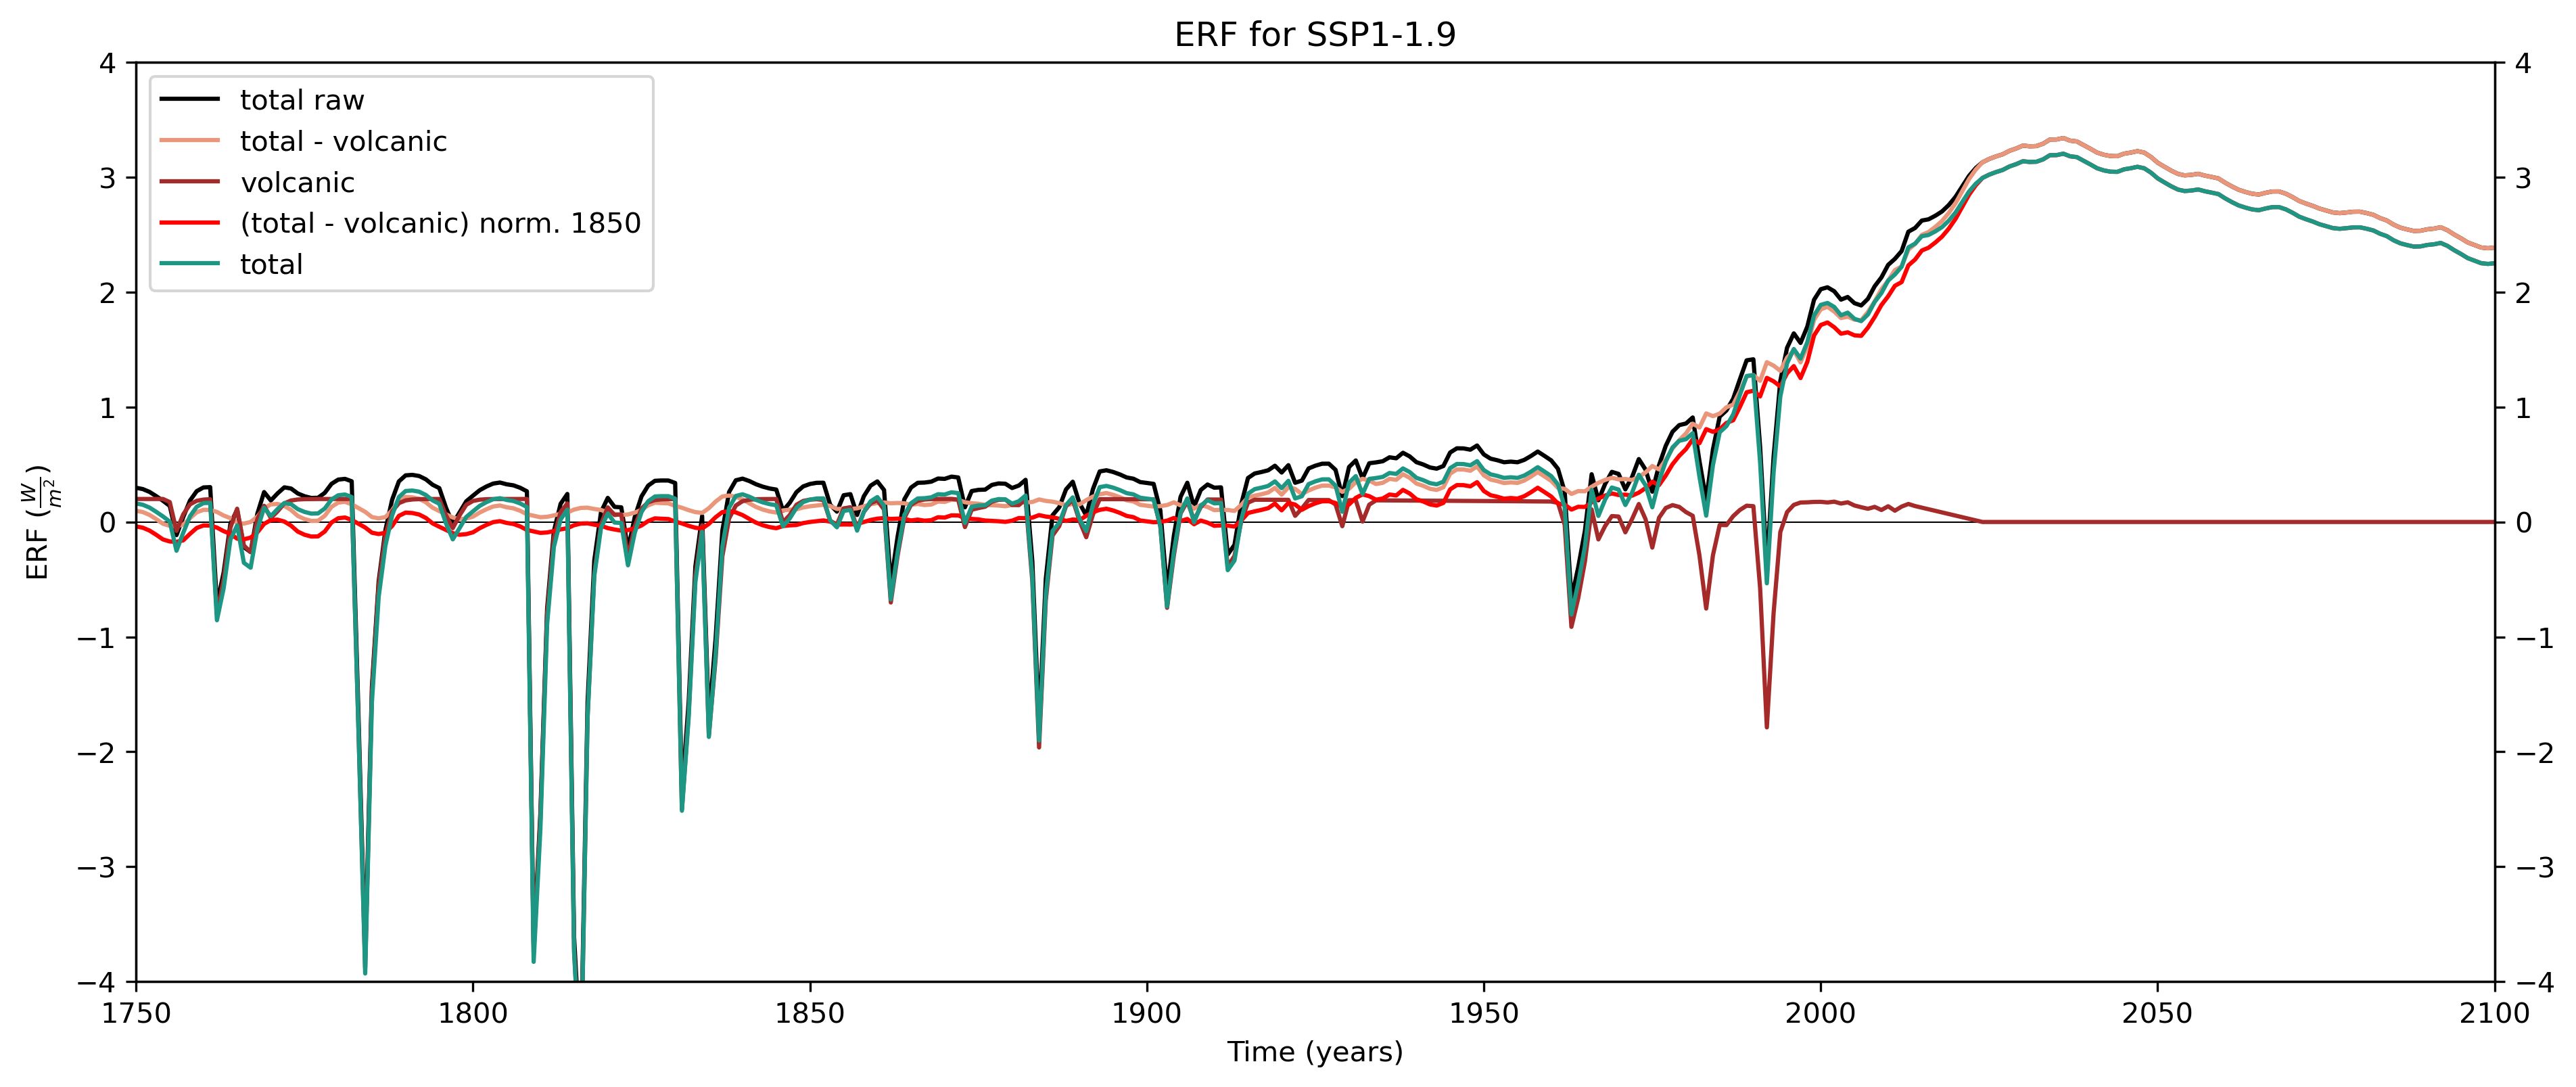

In [33]:
fig, axes = plt.subplots(1,1, figsize=(15,6))


axes.plot(erf_119_year,erf_119_total_raw,color='black',label="total raw")
axes.plot(erf_119_year,erf_119_novolcanic,color='darksalmon',label="total - volcanic")
axes.plot(erf_119_year,erf_119_volcanic,color='brown',label="volcanic")
axes.plot(erf_119_year,erf_119_novolcanic_norm,color='red',label="(total - volcanic) norm. 1850")
axes.plot(erf_119_year,erf_119_total,color=color_119,label="total")
# axes.plot(erf_119_year,erf_119_total_volc0,color=color_119,linestyle=':',label="total (volc. ERF = 0)")

legend = axes.legend(loc='upper left', shadow=False, fontsize='medium')

axes.plot([erf_119_year[0],erf_119_year[-1]],[0,0],color='black',linewidth=0.5,zorder=0)


axes.set_xlim([1750,2100])
axes.set_ylim([-4,4])
axes.set_xlabel('Time (years)')
axes.set_ylabel(r'ERF ($\frac{W}{m^2}$)')
axes.set_title('ERF for SSP1-1.9')

ax2 = axes.twinx()
mn, mx = axes.get_ylim()
ax2.set_ylim(mn, mx);






#### visualize forcing time series for all scenarios

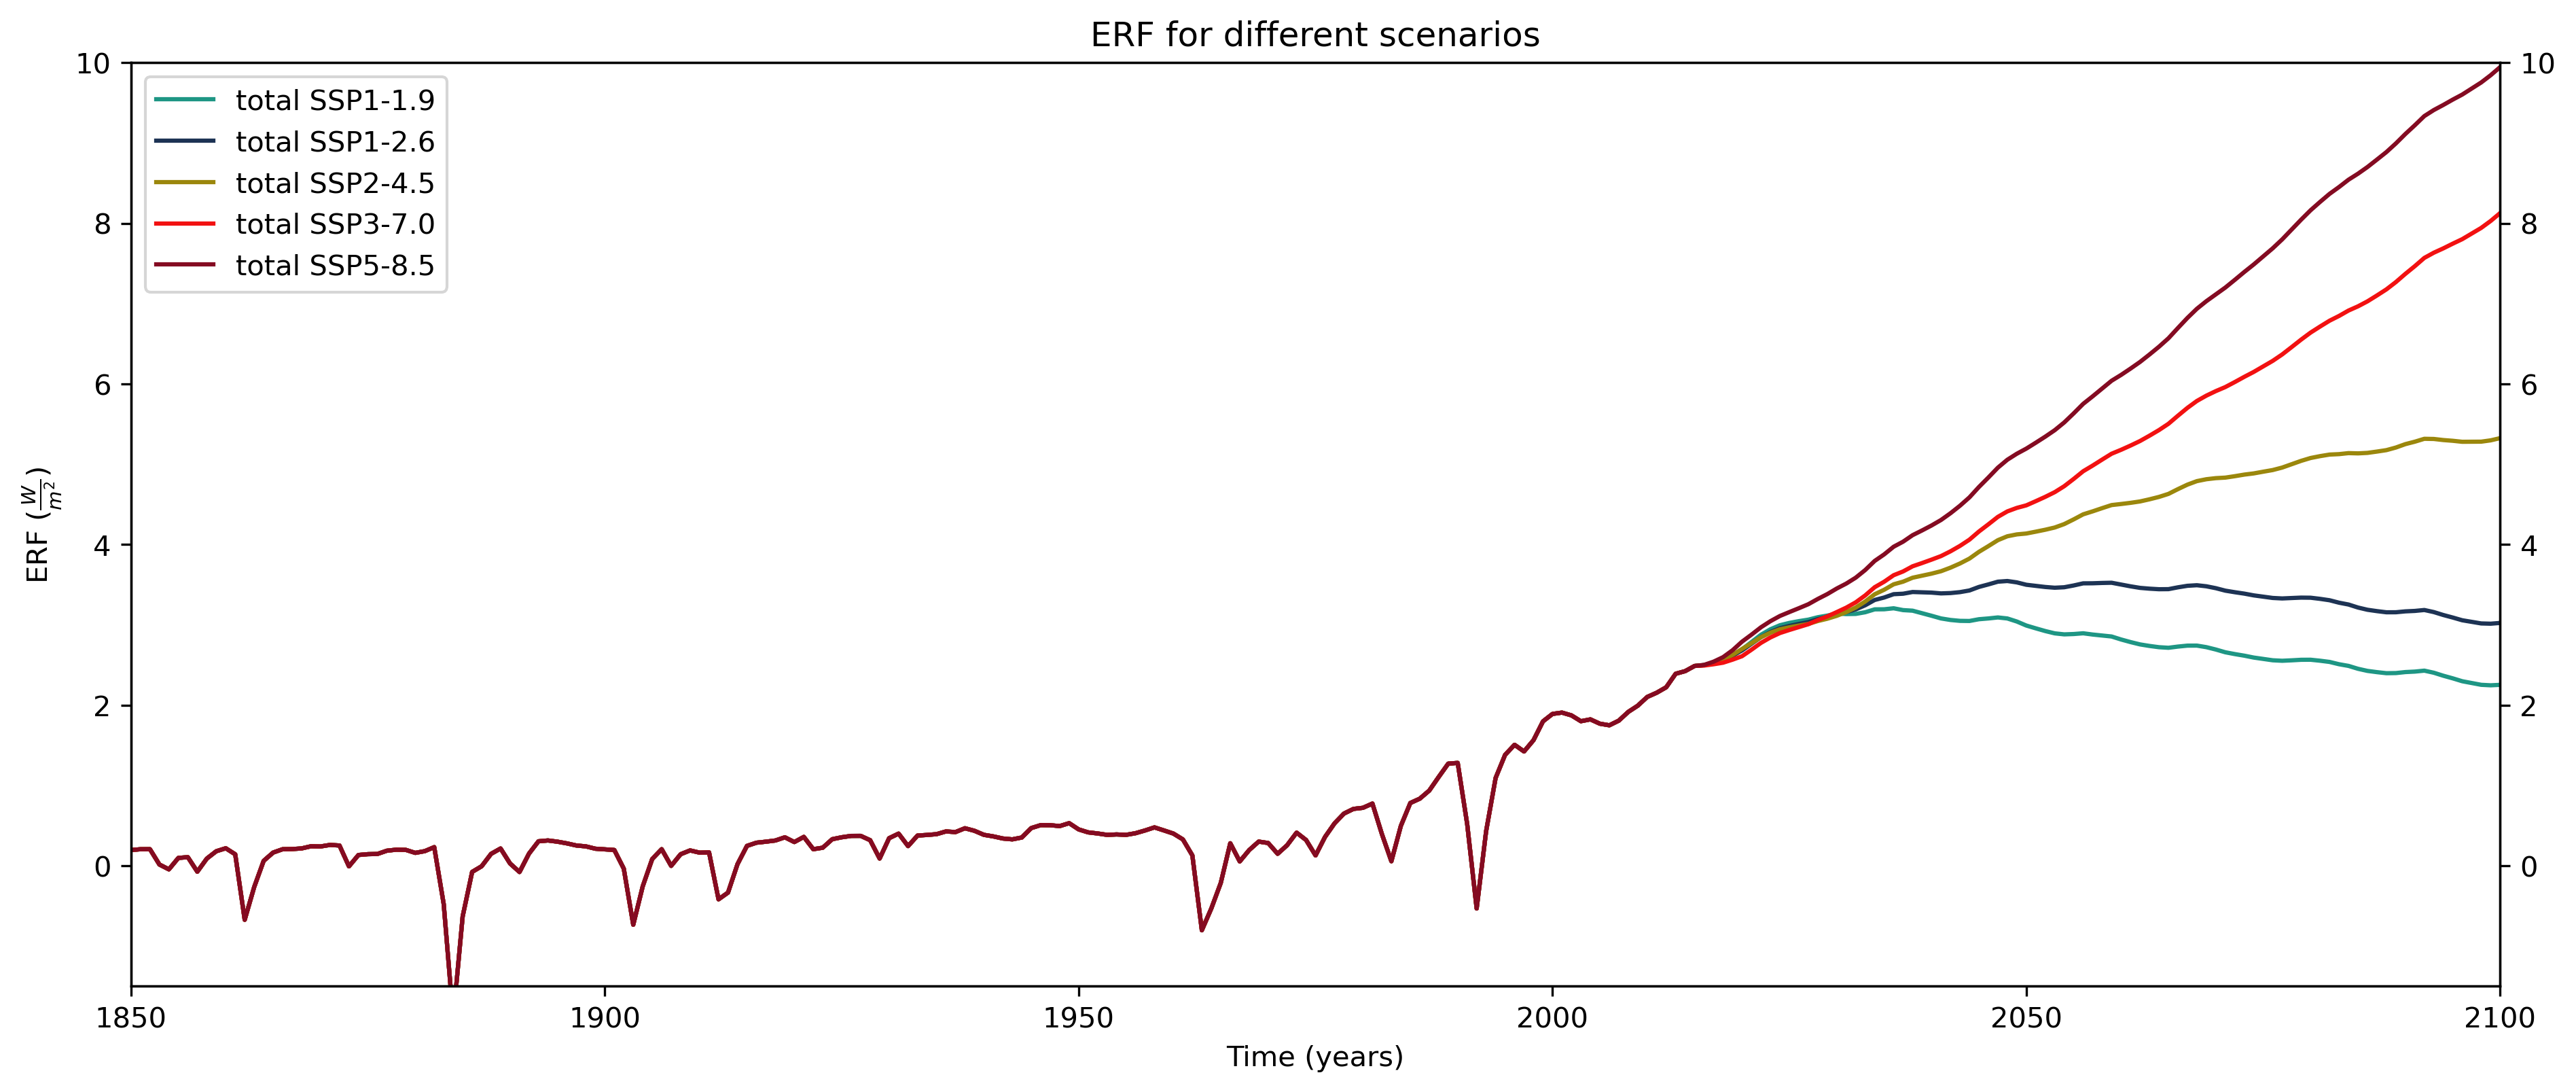

In [32]:
fig, axes = plt.subplots(1,1, figsize=(15,6))


axes.plot(erf_119_year,erf_119_total,color=color_119,label="total "+label_ssp119)


axes.plot(erf_126_year,erf_126_total,color=color_126,label="total "+label_ssp126)
axes.plot(erf_245_year,erf_245_total,color=color_245,label="total "+label_ssp245)
axes.plot(erf_370_year,erf_370_total,color=color_370,label="total "+label_ssp370)
axes.plot(erf_585_year,erf_585_total,color=color_585,label="total "+label_ssp585)


legend = axes.legend(loc='upper left', shadow=False, fontsize='medium')



axes.set_xlim([1850,2100])
axes.set_ylim([-1.5,10])
axes.set_xlabel('Time (years)')
axes.set_ylabel(r'ERF ($\frac{W}{m^2}$)')
axes.set_title('ERF for different scenarios')

ax2 = axes.twinx()
mn, mx = axes.get_ylim()
ax2.set_ylim(mn, mx);







### define the emulator

In [34]:
#--------------------------------------------------------------------------
# Function for the two-layer model
#
# inputs:
# forcing_years: a list of the years in the input_forcing
# input_forcing: the yearly forcing value
# ECS:           the equilibrium climate sensitivity
# TCR:           the transient climate response
# T_ml0:         the mixed-layer initial temperature
# T_deep0:       the deep ocean initial temperature
#
# alpha:         climate feedback parameter, computed from ERF and ECS
# kappa:         ocean heat uptake efficiency, computed from ERF, ECS, and TCR
#
#--------------------------------------------------------------------------

# settings for emulator
# Define time parameters in seconds:
hour       = 3600
day        = 24*hour
month      = 30*day
year       = 12*month


def twolayermodel(forcing_years, input_forcing, ECS=3.0, TCR=1.8, T_ml0=0.0, T_deep0=0.0):

    result = {}

    nyears     = np.size(forcing_years)
#     print('nyears =',nyears)
    delta_time = month
#     print('delta_time =',delta_time)
    nstep      = round(nyears*year/delta_time)
#     print('nstep =',nstep)
    time       = delta_time*np.arange(0,nstep,dtype=float) + min(forcing_years)*year
#     print('time =',time)
    timeyears  = time/year
#     print('timeyears =',timeyears)
    forcing    = np.interp(timeyears,forcing_years,input_forcing)

    # Parameters:
    density    = 1000.
    c_w        = 4181.
    C_ml       = 50*density*c_w # assuming 50m mixed layer
    C_deep     = 1200*density*c_w # assuming 1200m depp ocean
    alpha      = f2x/ECS
    
    kappa=(f2x/TCR)-(f2x/ECS)
    
    # Initialize state variables:
    T_ml       = np.zeros(nstep)
    T_deep     = np.zeros(nstep)
    T_ml[0]    = T_ml0
    T_deep[0]  = T_deep0
    imbalance  = np.zeros(nstep)
    
    # Integrate:
    imbalance[0] = np.nan 
    for t in range(0, nstep-1):
        T_ml[t+1]      = T_ml[t] + ( forcing[t] - (alpha*T_ml[t]) - (kappa*(T_ml[t]-T_deep[t])) ) * delta_time/C_ml
        T_deep[t+1]    = T_deep[t] + ( kappa*(T_ml[t]-T_deep[t]) * delta_time/C_deep )
        imbalance[t+1] = (C_ml*(T_ml[t+1]-T_ml[t]) + C_deep*(T_deep[t+1]-T_deep[t]))/delta_time
    
    # Output result and settings for this run:
    result['time'] = timeyears
    result['forcing'] = forcing
    result['T_ml'] = T_ml
    result['T_deep'] = T_deep
    result['imbalance'] = imbalance

    result['ECS'] = ECS
    result['TCR'] = TCR
    result['C_ml'] = C_ml
    result['C_deep'] = C_deep
    result['kappa'] = kappa
    result['alpha'] = alpha
        
    return result

### run the emulator
The emulator is using the forcing starting in 1850. For each of the five scenarios, the emulator is run for five different ECS/TCR pairs.

In [36]:
# use ERF from 1850 onwards
id6 = np.where(erf_126_year >= 1850)

In [37]:
exp_AR6_ssp119 = twolayermodel(erf_119_year[id6], erf_119_total[id6], ECS=ECS, TCR=TCR)
exp_AR6_ssp119_vll = twolayermodel(erf_119_year[id6], erf_119_total[id6], ECS=ECS_vll, TCR=TCR_vll)
exp_AR6_ssp119_vlh = twolayermodel(erf_119_year[id6], erf_119_total[id6], ECS=ECS_vlh, TCR=TCR_vlh)
exp_AR6_ssp119_ll = twolayermodel(erf_119_year[id6], erf_119_total[id6], ECS=ECS_ll, TCR=TCR_ll)
exp_AR6_ssp119_lh = twolayermodel(erf_119_year[id6], erf_119_total[id6], ECS=ECS_lh, TCR=TCR_lh)

exp_AR6_ssp126 = twolayermodel(erf_126_year[id6], erf_126_total[id6], ECS=ECS, TCR=TCR)
exp_AR6_ssp126_vll = twolayermodel(erf_126_year[id6], erf_126_total[id6], ECS=ECS_vll, TCR=TCR_vll)
exp_AR6_ssp126_vlh = twolayermodel(erf_126_year[id6], erf_126_total[id6], ECS=ECS_vlh, TCR=TCR_vlh)
exp_AR6_ssp126_ll = twolayermodel(erf_126_year[id6], erf_126_total[id6], ECS=ECS_ll, TCR=TCR_ll)
exp_AR6_ssp126_lh = twolayermodel(erf_126_year[id6], erf_126_total[id6], ECS=ECS_lh, TCR=TCR_lh)

exp_AR6_ssp245 = twolayermodel(erf_245_year[id6], erf_245_total[id6], ECS=ECS, TCR=TCR)
exp_AR6_ssp245_vll = twolayermodel(erf_245_year[id6], erf_245_total[id6], ECS=ECS_vll, TCR=TCR_vll)
exp_AR6_ssp245_vlh = twolayermodel(erf_245_year[id6], erf_245_total[id6], ECS=ECS_vlh, TCR=TCR_vlh)
exp_AR6_ssp245_ll = twolayermodel(erf_245_year[id6], erf_245_total[id6], ECS=ECS_ll, TCR=TCR_ll)
exp_AR6_ssp245_lh = twolayermodel(erf_245_year[id6], erf_245_total[id6], ECS=ECS_lh, TCR=TCR_lh)

exp_AR6_ssp370 = twolayermodel(erf_370_year[id6], erf_370_total[id6], ECS=ECS, TCR=TCR)
exp_AR6_ssp370_vll = twolayermodel(erf_370_year[id6], erf_370_total[id6], ECS=ECS_vll, TCR=TCR_vll)
exp_AR6_ssp370_vlh = twolayermodel(erf_370_year[id6], erf_370_total[id6], ECS=ECS_vlh, TCR=TCR_vlh)
exp_AR6_ssp370_ll = twolayermodel(erf_370_year[id6], erf_370_total[id6], ECS=ECS_ll, TCR=TCR_ll)
exp_AR6_ssp370_lh = twolayermodel(erf_370_year[id6], erf_370_total[id6], ECS=ECS_lh, TCR=TCR_lh)


exp_AR6_ssp585 = twolayermodel(erf_585_year[id6], erf_585_total[id6], ECS=ECS, TCR=TCR)
exp_AR6_ssp585_vll = twolayermodel(erf_585_year[id6], erf_585_total[id6], ECS=ECS_vll, TCR=TCR_vll)
exp_AR6_ssp585_vlh = twolayermodel(erf_585_year[id6], erf_585_total[id6], ECS=ECS_vlh, TCR=TCR_vlh)
exp_AR6_ssp585_ll = twolayermodel(erf_585_year[id6], erf_585_total[id6], ECS=ECS_ll, TCR=TCR_ll)
exp_AR6_ssp585_lh = twolayermodel(erf_585_year[id6], erf_585_total[id6], ECS=ECS_lh, TCR=TCR_lh)


<div class="alert alert-block alert-info"> <b>NOTE</b> For the analysis, we compute anomalies relative to the 1995-2014 reference period. Note that the offset is different for different ECS/TCR combinations, but the same for all scenarios because they have identical historical forcing for the reference period. </div>


In [39]:
# anomalies relative to reference period

offset = np.mean(exp_AR6_ssp126['T_ml']
                     [np.where((exp_AR6_ssp126['time'] >= refperiod_start) 
                               & (exp_AR6_ssp126['time'] < refperiod_end+1))])

offset_vll = np.mean(exp_AR6_ssp126_vll['T_ml']
                     [np.where((exp_AR6_ssp126_vll['time'] >= refperiod_start) 
                               & (exp_AR6_ssp126_vll['time'] < refperiod_end+1))])
offset_vlh = np.mean(exp_AR6_ssp126_vlh['T_ml']
                     [np.where((exp_AR6_ssp126_vlh['time'] >= refperiod_start) 
                               & (exp_AR6_ssp126_vlh['time'] < refperiod_end+1))])
offset_ll = np.mean(exp_AR6_ssp126_ll['T_ml']
                     [np.where((exp_AR6_ssp126_ll['time'] >= refperiod_start) 
                               & (exp_AR6_ssp126_ll['time'] < refperiod_end+1))])
offset_lh = np.mean(exp_AR6_ssp126_lh['T_ml']
                     [np.where((exp_AR6_ssp126_lh['time'] >= refperiod_start) 
                               & (exp_AR6_ssp126_lh['time'] < refperiod_end+1))])



# compute anomalies relative to reference period
exp_AR6_ssp119['T_ml']     = exp_AR6_ssp119['T_ml']     - offset
exp_AR6_ssp119_vll['T_ml'] = exp_AR6_ssp119_vll['T_ml'] - offset_vll
exp_AR6_ssp119_vlh['T_ml'] = exp_AR6_ssp119_vlh['T_ml'] - offset_vlh
exp_AR6_ssp119_ll['T_ml']  = exp_AR6_ssp119_ll['T_ml']  - offset_ll
exp_AR6_ssp119_lh['T_ml']  = exp_AR6_ssp119_lh['T_ml']  - offset_lh

exp_AR6_ssp126['T_ml']     = exp_AR6_ssp126['T_ml']     - offset
exp_AR6_ssp126_vll['T_ml'] = exp_AR6_ssp126_vll['T_ml'] - offset_vll
exp_AR6_ssp126_vlh['T_ml'] = exp_AR6_ssp126_vlh['T_ml'] - offset_vlh
exp_AR6_ssp126_ll['T_ml']  = exp_AR6_ssp126_ll['T_ml']  - offset_ll
exp_AR6_ssp126_lh['T_ml']  = exp_AR6_ssp126_lh['T_ml']  - offset_lh

exp_AR6_ssp245['T_ml']     = exp_AR6_ssp245['T_ml']     - offset
exp_AR6_ssp245_vll['T_ml'] = exp_AR6_ssp245_vll['T_ml'] - offset_vll
exp_AR6_ssp245_vlh['T_ml'] = exp_AR6_ssp245_vlh['T_ml'] - offset_vlh
exp_AR6_ssp245_ll['T_ml']  = exp_AR6_ssp245_ll['T_ml']  - offset_ll
exp_AR6_ssp245_lh['T_ml']  = exp_AR6_ssp245_lh['T_ml']  - offset_lh

exp_AR6_ssp370['T_ml']     = exp_AR6_ssp370['T_ml']     - offset
exp_AR6_ssp370_vll['T_ml'] = exp_AR6_ssp370_vll['T_ml'] - offset_vll
exp_AR6_ssp370_vlh['T_ml'] = exp_AR6_ssp370_vlh['T_ml'] - offset_vlh
exp_AR6_ssp370_ll['T_ml']  = exp_AR6_ssp370_ll['T_ml']  - offset_ll
exp_AR6_ssp370_lh['T_ml']  = exp_AR6_ssp370_lh['T_ml']  - offset_lh

exp_AR6_ssp585['T_ml']     = exp_AR6_ssp585['T_ml']     - offset
exp_AR6_ssp585_vll['T_ml'] = exp_AR6_ssp585_vll['T_ml'] - offset_vll
exp_AR6_ssp585_vlh['T_ml'] = exp_AR6_ssp585_vlh['T_ml'] - offset_vlh
exp_AR6_ssp585_ll['T_ml']  = exp_AR6_ssp585_ll['T_ml']  - offset_ll
exp_AR6_ssp585_lh['T_ml']  = exp_AR6_ssp585_lh['T_ml']  - offset_lh

### visualize the emulated GSAT change
Below, we visualize the emulated GSAT change relative to 1995-2014 for five different scenarios. Only the central estimates are shown here, but *likely* and *very likely* ranges can easily be added.

For example by adding this line for the SSP1-1.9 95% range:

`axes.plot(exp_AR6_ssp119_vlh['time'],exp_AR6_ssp119_vlh['T_ml'],color=color_119,linestyle=':',label="SSP1-1.9 95%")`

(-1.0, 4.5)

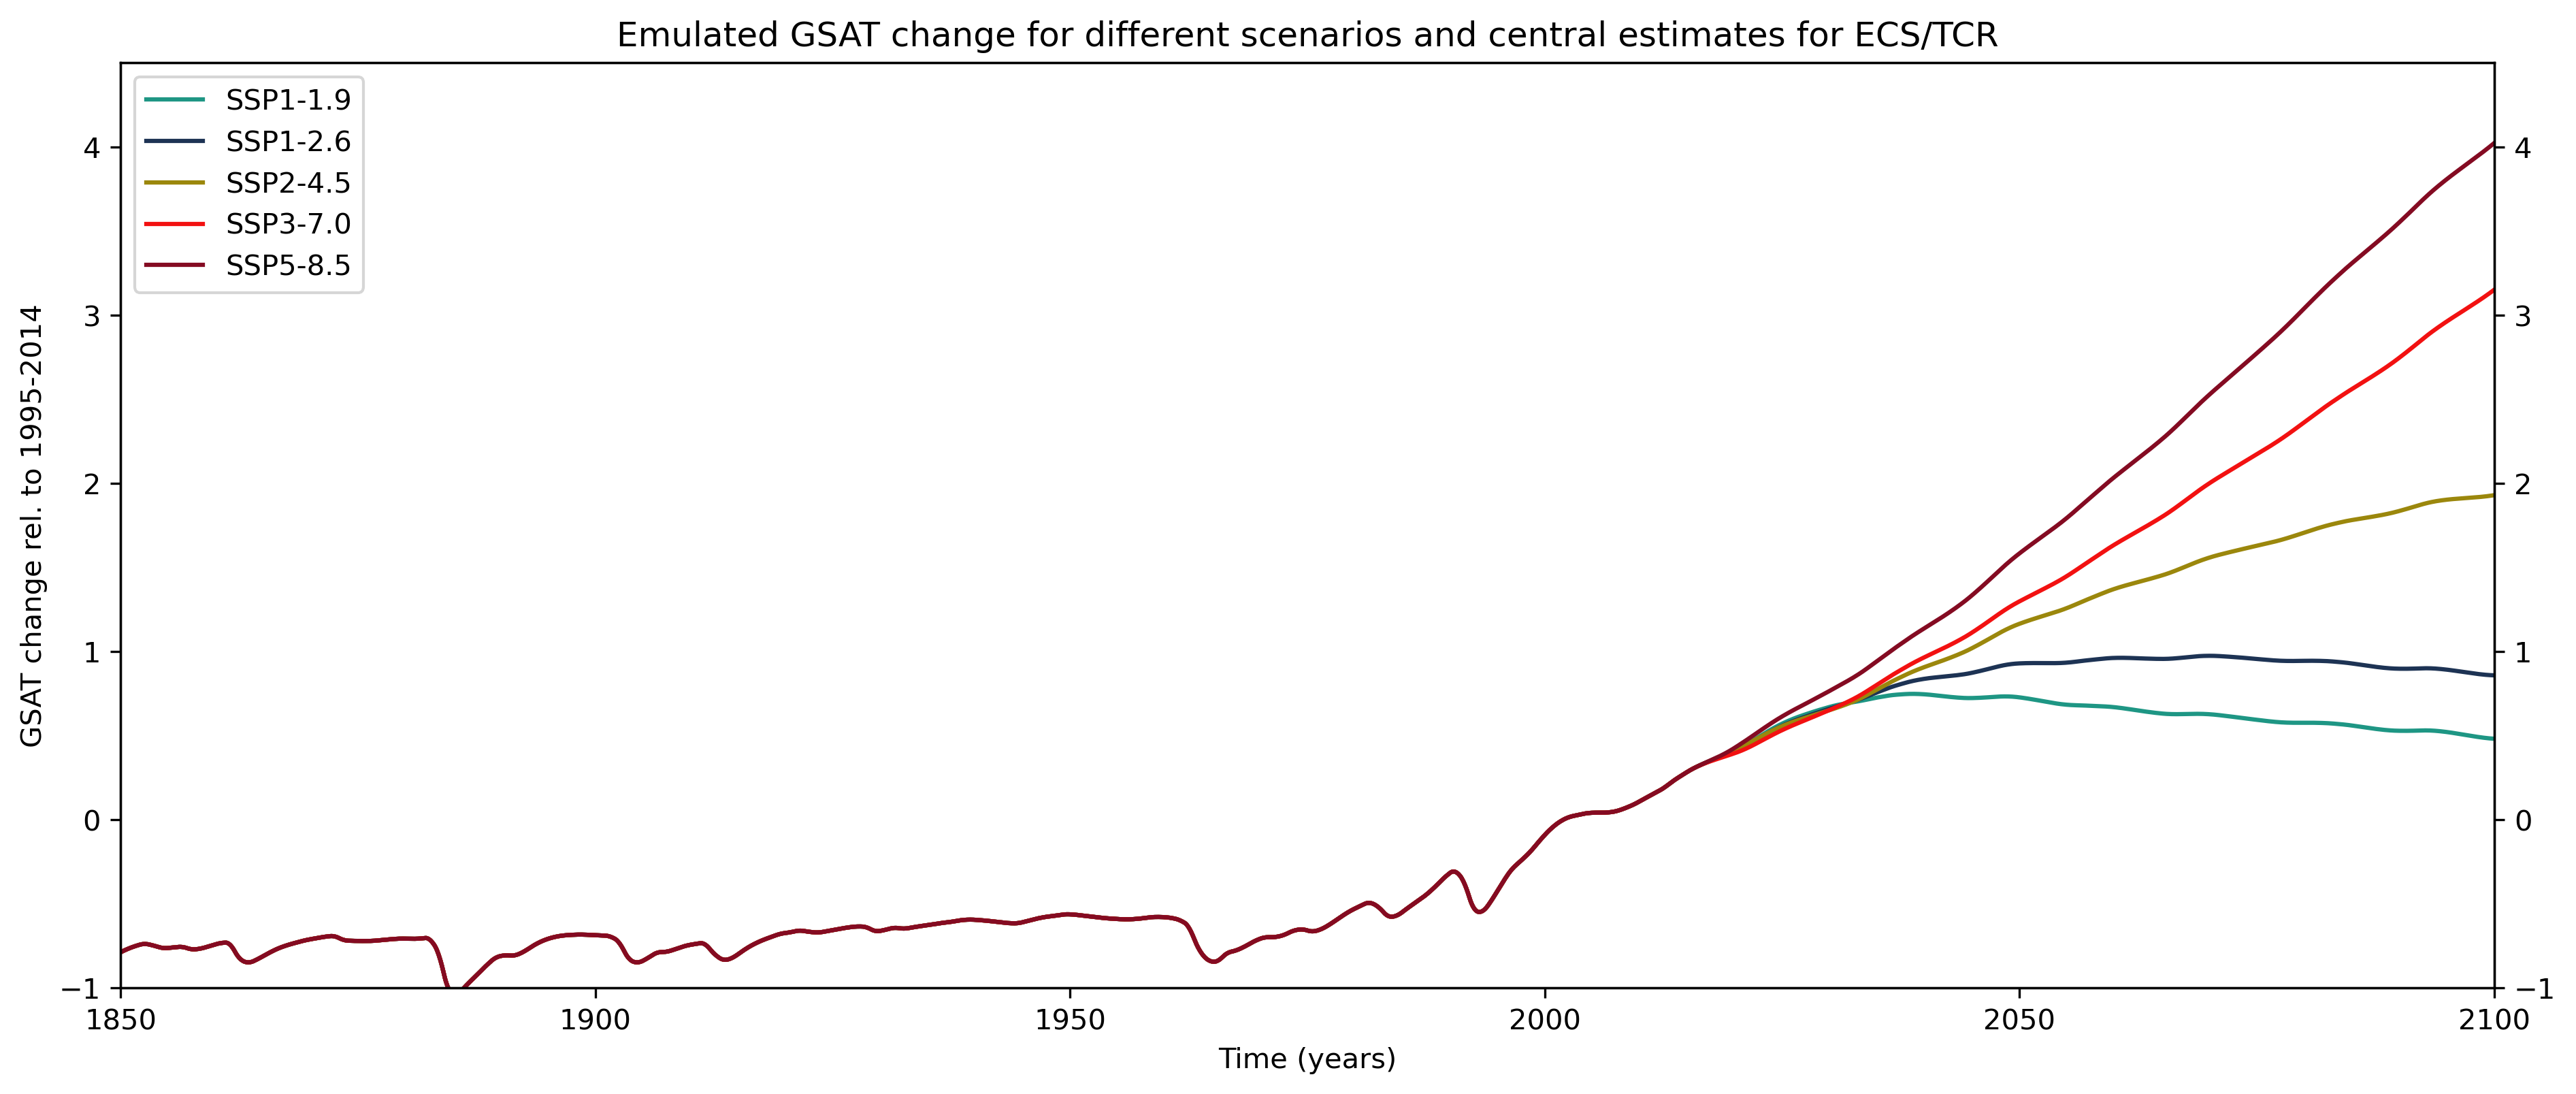

In [41]:
fig, axes = plt.subplots(1,1, figsize=(15,6))


axes.plot(exp_AR6_ssp119['time'],exp_AR6_ssp119['T_ml'],color=color_119,label="SSP1-1.9")
axes.plot(exp_AR6_ssp126['time'],exp_AR6_ssp126['T_ml'],color=color_126,label="SSP1-2.6")
axes.plot(exp_AR6_ssp245['time'],exp_AR6_ssp245['T_ml'],color=color_245,label="SSP2-4.5")
axes.plot(exp_AR6_ssp370['time'],exp_AR6_ssp370['T_ml'],color=color_370,label="SSP3-7.0")
axes.plot(exp_AR6_ssp585['time'],exp_AR6_ssp585['T_ml'],color=color_585,label="SSP5-8.5")
legend = axes.legend(loc='upper left', shadow=False, fontsize='medium')



axes.set_xlim([1850,2100])
axes.set_ylim([-1,4.5])
axes.set_xlabel('Time (years)')
axes.set_ylabel('GSAT change rel. to 1995-2014')
axes.set_title('Emulated GSAT change for different scenarios and central estimates for ECS/TCR')

ax2 = axes.twinx()
mn, mx = axes.get_ylim()
ax2.set_ylim(mn, mx)







For the next analysis steps, the emulator output is saved as an XArray Dataset. This makes it more convenient to export the output as netcdf files if desired.

In [46]:
def emulator_to_array(array_low,array_llow,array_median,array_lhigh,array_high):
    # computes annual mean time series from emulator
    # generates XArray DataArray
    # uses time series from 5 inputs: very_likely_low, likely_low, median, likely_high, very_likely_high
    # writes to netCDF
    time = []
    T_ml_median = []
    T_ml_low = []
    T_ml_high = []
    T_ml_llow = []
    T_ml_lhigh = []
    for y in range(0,int(len(array_median['time'])/12)):
        time.append(np.floor(np.mean(array_median['time'][y*12:y*12+12])))
        T_ml_median.append(np.mean(array_median['T_ml'][y*12:y*12+12]))
        T_ml_low.append(np.mean(array_low['T_ml'][y*12:y*12+12]))
        T_ml_high.append(np.mean(array_high['T_ml'][y*12:y*12+12]))
        T_ml_llow.append(np.mean(array_llow['T_ml'][y*12:y*12+12]))
        T_ml_lhigh.append(np.mean(array_lhigh['T_ml'][y*12:y*12+12]))
    # limit to 1850-2100 because pd.date_range can't handle 1850-2500
    emulator_array = xr.Dataset(data_vars={'Q05': (['time'],T_ml_low[0:251]),
                                           'Q17': (['time'],T_ml_llow[0:251]),
                                           'Q50': (['time'],T_ml_median[0:251]),
                                           'Q83': (['time'],T_ml_lhigh[0:251]),
                                           'Q95': (['time'],T_ml_high[0:251])},
                                  coords={'time': pd.date_range(str(int(time[0]))+'-01-01', periods=251, freq='A-JUL')},
                                  attrs={'ECS': [array_low['ECS'],array_llow['ECS'], array_median['ECS'], array_lhigh['ECS'],array_high['ECS']],
                                          'TCR': [array_low['TCR'],array_llow['TCR'], array_median['TCR'], array_lhigh['TCR'],array_high['TCR']],
                                          'Emulator version': 'AR6',
                                          'forcing DOI' : '10.5281/zenodo.3973015',
                                          'forcing version': 'v3.0'})
#     emulator_array.to_netcdf(filepath)
    return emulator_array

In [47]:
# one array for each scenario containing central estimate, likely range, and very likely range.

ssp119_emulator_raw = emulator_to_array(exp_AR6_ssp119_vll,exp_AR6_ssp119_ll,exp_AR6_ssp119,exp_AR6_ssp119_lh,exp_AR6_ssp119_vlh)
ssp126_emulator_raw = emulator_to_array(exp_AR6_ssp126_vll,exp_AR6_ssp126_ll,exp_AR6_ssp126,exp_AR6_ssp126_lh,exp_AR6_ssp126_vlh)
ssp245_emulator_raw = emulator_to_array(exp_AR6_ssp245_vll,exp_AR6_ssp245_ll,exp_AR6_ssp245,exp_AR6_ssp245_lh,exp_AR6_ssp245_vlh)
ssp370_emulator_raw = emulator_to_array(exp_AR6_ssp370_vll,exp_AR6_ssp370_ll,exp_AR6_ssp370,exp_AR6_ssp370_lh,exp_AR6_ssp370_vlh)
ssp585_emulator_raw = emulator_to_array(exp_AR6_ssp585_vll,exp_AR6_ssp585_ll,exp_AR6_ssp585,exp_AR6_ssp585_lh,exp_AR6_ssp585_vlh)

Note: you can write these datasets as netcdf files
`ssp119_emulator_raw.to_netcdf('/path_to_output_directory/output_file.nc')`

If you don't define a path and just the filename, the .nc file will be stored in the current working directory.

### 20-year means for emulator
Compute running 20-year means for the emulator output.

This is necessary to combine the emulator output with constrained CMIP6 results that are only available as 20-year means.

In [52]:
# compute running 20-year means (midpoint (start+0.5*windosize) as time axis)

def compute_runmean_midpoint(timeseries,meanlength=20):
    # compute running means for all x-year periods (default: 20-year mean)
    # 1850-1879 .. 2081-2100
    # computed for midpoint
    
    # initialise
    # try:
    startyear = pd.to_datetime(timeseries['time'][0].values).year
    lastyear = pd.to_datetime(timeseries['time'][-1].values).year
    # except: # because the Brunner et al. time series have a different time axis
    #     startyear = timeseries['year'][0].values
    #     lastyear = timeseries['year'][-1].values
    midyear = startyear + meanlength/2
    counter = 0
    nummean = lastyear - meanlength - startyear +2 # how many means are there for the chosen mean length?

#     # create empty array
#     try: # array with multiple realisations
#         enssize = len(timeseries['ensemble'])
#         # create array
#         timeseries_means = xr.DataArray(np.zeros([enssize, nummean]),
#                                     dims=('ensemble', 'time'),
#                                     coords={'ensemble': np.arange(1,enssize+1,1),
#                                            'time': pd.date_range(str(int(midyear))+'-01-01', periods=nummean, freq='A-JUL')},
#                                     attrs={'meanlength': meanlength})

#         # compute
#         for istartyear in tqdm(range(startyear,lastyear-meanlength+2)):
#             iendyear = istartyear + meanlength -1
#             for member in range(0,enssize):
#                 timeseries_means[member,istartyear-startyear] = \
#                     np.mean(timeseries.isel(ensemble=member).loc[str(istartyear)+'-01-01':str(iendyear)+'-12-31'])
#         return timeseries_means
    # except:
#         print('no ensemble!')
    timeseries_means = xr.DataArray(np.zeros([nummean]),
                                dims=('time'),
                                coords={'time': pd.date_range(str(int(midyear))+'-01-01', periods=nummean, freq='A-JUL')},
                                attrs={'meanlength': meanlength})

    # compute
    for istartyear in tqdm(range(startyear,lastyear-meanlength+2)):
        iendyear = istartyear + meanlength -1
        timeseries_means[istartyear-startyear] = \
            np.mean(timeseries.loc[str(istartyear)+'-01-01':str(iendyear)+'-12-31'])
    return timeseries_means





In [57]:
ssp119_emulator_means20_Q05 = compute_runmean_midpoint(ssp119_emulator_raw['Q05'],meanlength=20)
ssp119_emulator_means20_mean = compute_runmean_midpoint(ssp119_emulator_raw['Q50'],meanlength=20)
ssp119_emulator_means20_Q95 = compute_runmean_midpoint(ssp119_emulator_raw['Q95'],meanlength=20)
ssp119_emulator = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_emulator_means20_Q05),
                                            'mean': (['time'],  ssp119_emulator_means20_mean),
                                            'Q95': (['time'],  ssp119_emulator_means20_Q95)},
                coords={'time': ssp119_emulator_means20_mean['time']})


ssp126_emulator_means20_Q05 = compute_runmean_midpoint(ssp126_emulator_raw['Q05'],meanlength=20)
ssp126_emulator_means20_mean = compute_runmean_midpoint(ssp126_emulator_raw['Q50'],meanlength=20)
ssp126_emulator_means20_Q95 = compute_runmean_midpoint(ssp126_emulator_raw['Q95'],meanlength=20)
ssp126_emulator = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_emulator_means20_Q05),
                                            'mean': (['time'],  ssp126_emulator_means20_mean),
                                            'Q95': (['time'],  ssp126_emulator_means20_Q95)},
                coords={'time': ssp126_emulator_means20_mean['time']})

ssp245_emulator_means20_Q05 = compute_runmean_midpoint(ssp245_emulator_raw['Q05'],meanlength=20)
ssp245_emulator_means20_mean = compute_runmean_midpoint(ssp245_emulator_raw['Q50'],meanlength=20)
ssp245_emulator_means20_Q95 = compute_runmean_midpoint(ssp245_emulator_raw['Q95'],meanlength=20)
ssp245_emulator = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_emulator_means20_Q05),
                                            'mean': (['time'],  ssp245_emulator_means20_mean),
                                            'Q95': (['time'],  ssp245_emulator_means20_Q95)},
                coords={'time': ssp245_emulator_means20_mean['time']})

ssp370_emulator_means20_Q05 = compute_runmean_midpoint(ssp370_emulator_raw['Q05'],meanlength=20)
ssp370_emulator_means20_mean = compute_runmean_midpoint(ssp370_emulator_raw['Q50'],meanlength=20)
ssp370_emulator_means20_Q95 = compute_runmean_midpoint(ssp370_emulator_raw['Q95'],meanlength=20)
ssp370_emulator = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_emulator_means20_Q05),
                                            'mean': (['time'],  ssp370_emulator_means20_mean),
                                            'Q95': (['time'],  ssp370_emulator_means20_Q95)},
                coords={'time': ssp370_emulator_means20_mean['time']})



ssp585_emulator_means20_Q05 = compute_runmean_midpoint(ssp585_emulator_raw['Q05'],meanlength=20)
ssp585_emulator_means20_mean = compute_runmean_midpoint(ssp585_emulator_raw['Q50'],meanlength=20)
ssp585_emulator_means20_Q95 = compute_runmean_midpoint(ssp585_emulator_raw['Q95'],meanlength=20)
ssp585_emulator = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_emulator_means20_Q05),
                                            'mean': (['time'],  ssp585_emulator_means20_mean),
                                            'Q95': (['time'],  ssp585_emulator_means20_Q95)},
                coords={'time': ssp585_emulator_means20_mean['time']})





100%|██████████| 232/232 [00:00<00:00, 559.06it/s]


## Load constrained CMIP6 projections
The assessed GSAT projections are based on three published constrained CMIP6 ensembles and the emulator defined above (see also box 4.1 and section 4.3.4).

### Liang et al. (2020)
https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019GL086757

Notes on the data files:
- CSV files naming rules: for future projections, cdf_xxx (SSP scenarios).csv; for historical period cdf_his_xxx (historical constraint related to corresponding projected scenarios).csv
- The original datasets introduced in this study are 20 year running means of CMIP6 model simulations described in Table1. Here the changes of global mean near surface air temperature for projected period are provided (base period :1995-2014).
- Each csv file provides every year projection on cumulative frequency (‘cdf_p’ in csv files) with corresponding projections for weighted (‘cdf’) and unweighted (‘cdf_e’) approach. The csv files also provide each year best estimates of weighted (‘mean_w’) and unweighted (‘mean_e’) approach.

In [58]:
datdir_liang = basedir_data + 'constrained_cmip6/Liang/'

#### SSP1-2.6

In [60]:

data_his =pd.read_csv(datdir_liang + 'cdf_his_126.csv')

## import variable 
whis=data_his['cdf'] # weighted cdf
ehis=data_his['cdf_e'] # unweighted cdf
ehism=data_his['mean_e'] # unweighted mean
whism=data_his['mean_w'] # weighted mean

year=np.arange(1996, 2015)

w_his_05=[]
w_his_50=[]
w_his_95=[]
e_his_05=[]
e_his_50=[]
e_his_95=[]
whis_m=[]
ehis_m=[]

for i in range(np.size(year)):
    ## for every year, read weighted results with 5%, 50%, and 95% percentitle and means 
    his_05=float(whis[i].strip('][').split(',')[5])
    his_50=float(whis[i].strip('][').split(',')[50])
    his_95=float(whis[i].strip('][').split(',')[95])
    his_mw=whism[i]
    w_his_05=np.append(w_his_05,his_05)
    w_his_50=np.append(w_his_50,his_50)
    w_his_95=np.append(w_his_95,his_95)
    whis_m=np.append(whis_m,his_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    ehis_05=float(ehis[i].strip('][').split(',')[5])
    ehis_50=float(ehis[i].strip('][').split(',')[50])
    ehis_95=float(ehis[i].strip('][').split(',')[95])
    ehis_me=ehism[i]
    e_his_05=np.append(e_his_05,ehis_05)
    e_his_50=np.append(e_his_50,ehis_50)
    e_his_95=np.append(e_his_95,ehis_95)
    ehis_m=np.append(ehis_m,ehis_me)

data_ssp126 =pd.read_csv(datdir_liang + 'cdf_126.csv')

## import variable 
wssp126=data_ssp126['cdf']
essp126=data_ssp126['cdf_e']
essp126m=data_ssp126['mean_e']
wssp126m=data_ssp126['mean_w']

year_126=np.arange(2015, 2081)

w_ssp126_05=[]
w_ssp126_50=[]
w_ssp126_95=[]
e_ssp126_05=[]
e_ssp126_50=[]
e_ssp126_95=[]
wssp126_m=[]
essp126_m=[]

for i in range(np.size(year_126)):
    ## for every year, read weighted results with 5% and 95% percentitle and means 
    ssp126_05=float(wssp126[i].strip('][').split(',')[5])
    ssp126_50=float(wssp126[i].strip('][').split(',')[50])
    ssp126_95=float(wssp126[i].strip('][').split(',')[95])
    ssp126_mw=wssp126m[i]
    w_ssp126_05=np.append(w_ssp126_05,ssp126_05)
    w_ssp126_50=np.append(w_ssp126_50,ssp126_50)
    w_ssp126_95=np.append(w_ssp126_95,ssp126_95)
    wssp126_m=np.append(wssp126_m,ssp126_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    essp126_05=float(essp126[i].strip('][').split(',')[5])
    essp126_50=float(essp126[i].strip('][').split(',')[50])
    essp126_95=float(essp126[i].strip('][').split(',')[95])
    essp126_me=essp126m[i]
    e_ssp126_05=np.append(e_ssp126_05,essp126_05)
    e_ssp126_50=np.append(e_ssp126_50,essp126_50)
    e_ssp126_95=np.append(e_ssp126_95,essp126_95)
    essp126_m=np.append(essp126_m,essp126_me)

# extrapolate last 10 values linearly by 1 year to compute value for 2081-2100 and append to time series
w_ssp126_05=np.append(w_ssp126_05,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp126_05[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp126_50=np.append(w_ssp126_50,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp126_50[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp126_95=np.append(w_ssp126_95,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp126_95[-10:], 1))(np.linspace(1,11,11))[-1])
wssp126_m=np.append(wssp126_m,np.poly1d(np.polyfit(np.linspace(1,10,10), wssp126_m[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp126_05=np.append(e_ssp126_05,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp126_05[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp126_50=np.append(e_ssp126_50,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp126_50[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp126_95=np.append(e_ssp126_95,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp126_95[-10:], 1))(np.linspace(1,11,11))[-1])
essp126_m=np.append(essp126_m,np.poly1d(np.polyfit(np.linspace(1,10,10), essp126_m[-10:], 1))(np.linspace(1,11,11))[-1])

# constrained
ssp126_yongxiao = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((w_his_05,w_ssp126_05))),
                                            'median': (['time'],  np.concatenate((w_his_50,w_ssp126_50))),
                                            'mean': (['time'],  np.concatenate((whis_m,wssp126_m))),
                                            'Q95': (['time'],  np.concatenate((w_his_95,w_ssp126_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

# unconstrained
ssp126_yongxiao_raw = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((e_his_05,e_ssp126_05))),
                                            'median': (['time'],  np.concatenate((e_his_50,e_ssp126_50))),
                                            'mean': (['time'],  np.concatenate((ehis_m,essp126_m))),
                                            'Q95': (['time'],  np.concatenate((e_his_95,e_ssp126_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

#### SSP2-4.5

In [61]:

data_his =pd.read_csv(datdir_liang + 'cdf_his_245.csv')

## import variable 
whis=data_his['cdf'] # weighted cdf
ehis=data_his['cdf_e'] # unweighted cdf
ehism=data_his['mean_e'] # unweighted mean
whism=data_his['mean_w'] # weighted mean

year=np.arange(1996, 2015)

w_his_05=[]
w_his_50=[]
w_his_95=[]
e_his_05=[]
e_his_50=[]
e_his_95=[]
whis_m=[]
ehis_m=[]

for i in range(np.size(year)):
    ## for every year, read weighted results with 5%, 50%, and 95% percentitle and means 
    his_05=float(whis[i].strip('][').split(',')[5])
    his_50=float(whis[i].strip('][').split(',')[50])
    his_95=float(whis[i].strip('][').split(',')[95])
    his_mw=whism[i]
    w_his_05=np.append(w_his_05,his_05)
    w_his_50=np.append(w_his_50,his_50)
    w_his_95=np.append(w_his_95,his_95)
    whis_m=np.append(whis_m,his_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    ehis_05=float(ehis[i].strip('][').split(',')[5])
    ehis_50=float(ehis[i].strip('][').split(',')[50])
    ehis_95=float(ehis[i].strip('][').split(',')[95])
    ehis_me=ehism[i]
    e_his_05=np.append(e_his_05,ehis_05)
    e_his_50=np.append(e_his_50,ehis_50)
    e_his_95=np.append(e_his_95,ehis_95)
    ehis_m=np.append(ehis_m,ehis_me)

data_ssp245 =pd.read_csv(datdir_liang + 'cdf_245.csv')

## import variable 
wssp245=data_ssp245['cdf']
essp245=data_ssp245['cdf_e']
essp245m=data_ssp245['mean_e']
wssp245m=data_ssp245['mean_w']

year_245=np.arange(2015, 2081)

w_ssp245_05=[]
w_ssp245_50=[]
w_ssp245_95=[]
e_ssp245_05=[]
e_ssp245_50=[]
e_ssp245_95=[]
wssp245_m=[]
essp245_m=[]

for i in range(np.size(year_245)):
    ## for every year, read weighted results with 5% and 95% percentitle and means 
    ssp245_05=float(wssp245[i].strip('][').split(',')[5])
    ssp245_50=float(wssp245[i].strip('][').split(',')[50])
    ssp245_95=float(wssp245[i].strip('][').split(',')[95])
    ssp245_mw=wssp245m[i]
    w_ssp245_05=np.append(w_ssp245_05,ssp245_05)
    w_ssp245_50=np.append(w_ssp245_50,ssp245_50)
    w_ssp245_95=np.append(w_ssp245_95,ssp245_95)
    wssp245_m=np.append(wssp245_m,ssp245_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    essp245_05=float(essp245[i].strip('][').split(',')[5])
    essp245_50=float(essp245[i].strip('][').split(',')[50])
    essp245_95=float(essp245[i].strip('][').split(',')[95])
    essp245_me=essp245m[i]
    e_ssp245_05=np.append(e_ssp245_05,essp245_05)
    e_ssp245_50=np.append(e_ssp245_50,essp245_50)
    e_ssp245_95=np.append(e_ssp245_95,essp245_95)
    essp245_m=np.append(essp245_m,essp245_me)

# extrapolate last 10 values linearly by 1 year to compute value for 2081-2100 and append to time series
w_ssp245_05=np.append(w_ssp245_05,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp245_05[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp245_50=np.append(w_ssp245_50,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp245_50[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp245_95=np.append(w_ssp245_95,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp245_95[-10:], 1))(np.linspace(1,11,11))[-1])
wssp245_m=np.append(wssp245_m,np.poly1d(np.polyfit(np.linspace(1,10,10), wssp245_m[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp245_05=np.append(e_ssp245_05,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp245_05[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp245_50=np.append(e_ssp245_50,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp245_50[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp245_95=np.append(e_ssp245_95,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp245_95[-10:], 1))(np.linspace(1,11,11))[-1])
essp245_m=np.append(essp245_m,np.poly1d(np.polyfit(np.linspace(1,10,10), essp245_m[-10:], 1))(np.linspace(1,11,11))[-1])

ssp245_yongxiao = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((w_his_05,w_ssp245_05))),
                                            'median': (['time'],  np.concatenate((w_his_50,w_ssp245_50))),
                                            'mean': (['time'],  np.concatenate((whis_m,wssp245_m))),
                                            'Q95': (['time'],  np.concatenate((w_his_95,w_ssp245_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

ssp245_yongxiao_raw = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((e_his_05,e_ssp245_05))),
                                            'median': (['time'],  np.concatenate((e_his_50,e_ssp245_50))),
                                            'mean': (['time'],  np.concatenate((ehis_m,essp245_m))),
                                            'Q95': (['time'],  np.concatenate((e_his_95,e_ssp245_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

#### SSP3-7.0

In [62]:

data_his =pd.read_csv(datdir_liang + 'cdf_his_370.csv')

## import variable 
whis=data_his['cdf'] # weighted cdf
ehis=data_his['cdf_e'] # unweighted cdf
ehism=data_his['mean_e'] # unweighted mean
whism=data_his['mean_w'] # weighted mean

year=np.arange(1996, 2015)

w_his_05=[]
w_his_50=[]
w_his_95=[]
e_his_05=[]
e_his_50=[]
e_his_95=[]
whis_m=[]
ehis_m=[]

for i in range(np.size(year)):
    ## for every year, read weighted results with 5%, 50%, and 95% percentitle and means 
    his_05=float(whis[i].strip('][').split(',')[5])
    his_50=float(whis[i].strip('][').split(',')[50])
    his_95=float(whis[i].strip('][').split(',')[95])
    his_mw=whism[i]
    w_his_05=np.append(w_his_05,his_05)
    w_his_50=np.append(w_his_50,his_50)
    w_his_95=np.append(w_his_95,his_95)
    whis_m=np.append(whis_m,his_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    ehis_05=float(ehis[i].strip('][').split(',')[5])
    ehis_50=float(ehis[i].strip('][').split(',')[50])
    ehis_95=float(ehis[i].strip('][').split(',')[95])
    ehis_me=ehism[i]
    e_his_05=np.append(e_his_05,ehis_05)
    e_his_50=np.append(e_his_50,ehis_50)
    e_his_95=np.append(e_his_95,ehis_95)
    ehis_m=np.append(ehis_m,ehis_me)

data_ssp370 =pd.read_csv(datdir_liang + 'cdf_370.csv')

## import variable 
wssp370=data_ssp370['cdf']
essp370=data_ssp370['cdf_e']
essp370m=data_ssp370['mean_e']
wssp370m=data_ssp370['mean_w']

year_370=np.arange(2015, 2081)

w_ssp370_05=[]
w_ssp370_50=[]
w_ssp370_95=[]
e_ssp370_05=[]
e_ssp370_50=[]
e_ssp370_95=[]
wssp370_m=[]
essp370_m=[]

for i in range(np.size(year_370)):
    ## for every year, read weighted results with 5% and 95% percentitle and means 
    ssp370_05=float(wssp370[i].strip('][').split(',')[5])
    ssp370_50=float(wssp370[i].strip('][').split(',')[50])
    ssp370_95=float(wssp370[i].strip('][').split(',')[95])
    ssp370_mw=wssp370m[i]
    w_ssp370_05=np.append(w_ssp370_05,ssp370_05)
    w_ssp370_50=np.append(w_ssp370_50,ssp370_50)
    w_ssp370_95=np.append(w_ssp370_95,ssp370_95)
    wssp370_m=np.append(wssp370_m,ssp370_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    essp370_05=float(essp370[i].strip('][').split(',')[5])
    essp370_50=float(essp370[i].strip('][').split(',')[50])
    essp370_95=float(essp370[i].strip('][').split(',')[95])
    essp370_me=essp370m[i]
    e_ssp370_05=np.append(e_ssp370_05,essp370_05)
    e_ssp370_50=np.append(e_ssp370_50,essp370_50)
    e_ssp370_95=np.append(e_ssp370_95,essp370_95)
    essp370_m=np.append(essp370_m,essp370_me)

# extrapolate last 10 values linearly by 1 year to compute value for 2081-2100 and append to time series
w_ssp370_05=np.append(w_ssp370_05,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp370_05[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp370_50=np.append(w_ssp370_50,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp370_50[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp370_95=np.append(w_ssp370_95,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp370_95[-10:], 1))(np.linspace(1,11,11))[-1])
wssp370_m=np.append(wssp370_m,np.poly1d(np.polyfit(np.linspace(1,10,10), wssp370_m[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp370_05=np.append(e_ssp370_05,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp370_05[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp370_50=np.append(e_ssp370_50,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp370_50[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp370_95=np.append(e_ssp370_95,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp370_95[-10:], 1))(np.linspace(1,11,11))[-1])
essp370_m=np.append(essp370_m,np.poly1d(np.polyfit(np.linspace(1,10,10), essp370_m[-10:], 1))(np.linspace(1,11,11))[-1])

ssp370_yongxiao = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((w_his_05,w_ssp370_05))),
                                            'median': (['time'],  np.concatenate((w_his_50,w_ssp370_50))),
                                            'mean': (['time'],  np.concatenate((whis_m,wssp370_m))),
                                            'Q95': (['time'],  np.concatenate((w_his_95,w_ssp370_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

ssp370_yongxiao_raw = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((e_his_05,e_ssp370_05))),
                                            'median': (['time'],  np.concatenate((e_his_50,e_ssp370_50))),
                                            'mean': (['time'],  np.concatenate((ehis_m,essp370_m))),
                                            'Q95': (['time'],  np.concatenate((e_his_95,e_ssp370_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

#### SSP5-8.5

In [63]:

data_his =pd.read_csv(datdir_liang + 'cdf_his_585.csv')

## import variable 
whis=data_his['cdf'] # weighted cdf
ehis=data_his['cdf_e'] # unweighted cdf
ehism=data_his['mean_e'] # unweighted mean
whism=data_his['mean_w'] # weighted mean

year=np.arange(1996, 2015)

w_his_05=[]
w_his_50=[]
w_his_95=[]
e_his_05=[]
e_his_50=[]
e_his_95=[]
whis_m=[]
ehis_m=[]

for i in range(np.size(year)):
    ## for every year, read weighted results with 5%, 50%, and 95% percentitle and means 
    his_05=float(whis[i].strip('][').split(',')[5])
    his_50=float(whis[i].strip('][').split(',')[50])
    his_95=float(whis[i].strip('][').split(',')[95])
    his_mw=whism[i]
    w_his_05=np.append(w_his_05,his_05)
    w_his_50=np.append(w_his_50,his_50)
    w_his_95=np.append(w_his_95,his_95)
    whis_m=np.append(whis_m,his_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    ehis_05=float(ehis[i].strip('][').split(',')[5])
    ehis_50=float(ehis[i].strip('][').split(',')[50])
    ehis_95=float(ehis[i].strip('][').split(',')[95])
    ehis_me=ehism[i]
    e_his_05=np.append(e_his_05,ehis_05)
    e_his_50=np.append(e_his_50,ehis_50)
    e_his_95=np.append(e_his_95,ehis_95)
    ehis_m=np.append(ehis_m,ehis_me)

data_ssp585 =pd.read_csv(datdir_liang + 'cdf_585.csv')

## import variable 
wssp585=data_ssp585['cdf']
essp585=data_ssp585['cdf_e']
essp585m=data_ssp585['mean_e']
wssp585m=data_ssp585['mean_w']

year_585=np.arange(2015, 2081)

w_ssp585_05=[]
w_ssp585_50=[]
w_ssp585_95=[]
e_ssp585_05=[]
e_ssp585_50=[]
e_ssp585_95=[]
wssp585_m=[]
essp585_m=[]

for i in range(np.size(year_585)):
    ## for every year, read weighted results with 5% and 95% percentitle and means 
    ssp585_05=float(wssp585[i].strip('][').split(',')[5])
    ssp585_50=float(wssp585[i].strip('][').split(',')[50])
    ssp585_95=float(wssp585[i].strip('][').split(',')[95])
    ssp585_mw=wssp585m[i]
    w_ssp585_05=np.append(w_ssp585_05,ssp585_05)
    w_ssp585_50=np.append(w_ssp585_50,ssp585_50)
    w_ssp585_95=np.append(w_ssp585_95,ssp585_95)
    wssp585_m=np.append(wssp585_m,ssp585_mw)

    ## for every year, read unweighted results with 5% and 95% percentitle and means
    essp585_05=float(essp585[i].strip('][').split(',')[5])
    essp585_50=float(essp585[i].strip('][').split(',')[50])
    essp585_95=float(essp585[i].strip('][').split(',')[95])
    essp585_me=essp585m[i]
    e_ssp585_05=np.append(e_ssp585_05,essp585_05)
    e_ssp585_50=np.append(e_ssp585_50,essp585_50)
    e_ssp585_95=np.append(e_ssp585_95,essp585_95)
    essp585_m=np.append(essp585_m,essp585_me)

# extrapolate last 10 values linearly by 1 year to compute value for 2081-2100 and append to time series
w_ssp585_05=np.append(w_ssp585_05,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp585_05[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp585_50=np.append(w_ssp585_50,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp585_50[-10:], 1))(np.linspace(1,11,11))[-1])
w_ssp585_95=np.append(w_ssp585_95,np.poly1d(np.polyfit(np.linspace(1,10,10), w_ssp585_95[-10:], 1))(np.linspace(1,11,11))[-1])
wssp585_m=np.append(wssp585_m,np.poly1d(np.polyfit(np.linspace(1,10,10), wssp585_m[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp585_05=np.append(e_ssp585_05,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp585_05[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp585_50=np.append(e_ssp585_50,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp585_50[-10:], 1))(np.linspace(1,11,11))[-1])
e_ssp585_95=np.append(e_ssp585_95,np.poly1d(np.polyfit(np.linspace(1,10,10), e_ssp585_95[-10:], 1))(np.linspace(1,11,11))[-1])
essp585_m=np.append(essp585_m,np.poly1d(np.polyfit(np.linspace(1,10,10), essp585_m[-10:], 1))(np.linspace(1,11,11))[-1])

ssp585_yongxiao = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((w_his_05,w_ssp585_05))),
                                            'median': (['time'],  np.concatenate((w_his_50,w_ssp585_50))),
                                            'mean': (['time'],  np.concatenate((whis_m,wssp585_m))),
                                            'Q95': (['time'],  np.concatenate((w_his_95,w_ssp585_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

ssp585_yongxiao_raw = xr.Dataset(data_vars={'Q05': (['time'],  np.concatenate((e_his_05,e_ssp585_05))),
                                            'median': (['time'],  np.concatenate((e_his_50,e_ssp585_50))),
                                            'mean': (['time'],  np.concatenate((ehis_m,essp585_m))),
                                            'Q95': (['time'],  np.concatenate((e_his_95,e_ssp585_95)))},
                coords={'time': pd.date_range('2006-01-01', periods=86, freq='A-JUL') })

### Tokarska et. al (2020)
https://www.science.org/doi/10.1126/sciadv.aaz9549

In [65]:
datdir = basedir_data + 'constrained_cmip6/Tokarska/'
# constrained
data_tokarska_constrained_119= np.genfromtxt(datdir+'ssp119.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_126= np.genfromtxt(datdir+'ssp126.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_245= np.genfromtxt(datdir+'ssp245.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_370= np.genfromtxt(datdir+'ssp370.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_585= np.genfromtxt(datdir+'ssp585.csv',delimiter=',', skip_header=1)

#raw
data_tokarska_constrained_119_raw= np.genfromtxt(datdir+'ssp119_raw.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_126_raw= np.genfromtxt(datdir+'ssp126_raw.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_245_raw= np.genfromtxt(datdir+'ssp245_raw.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_370_raw= np.genfromtxt(datdir+'ssp370_raw.csv',delimiter=',', skip_header=1)
data_tokarska_constrained_585_raw= np.genfromtxt(datdir+'ssp585_raw.csv',delimiter=',', skip_header=1)

#### constrained

In [66]:
# process csv data and save as XArray Datasets
# SSP119
year_tokarska        = data_tokarska_constrained_119[:,0]
ssp119_Q05  = data_tokarska_constrained_119[:,3]
ssp119_mean = data_tokarska_constrained_119[:,5]
ssp119_median = data_tokarska_constrained_119[:,6]
ssp119_Q95  = data_tokarska_constrained_119[:,4]

# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp119_Q05=np.append(ssp119_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_median=np.append(ssp119_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_Q95=np.append(ssp119_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_mean=np.append(ssp119_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp119_tokarska = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_Q05),
                                            'mean': (['time'],  ssp119_mean),
                                            'median': (['time'],  ssp119_median),
                                            'Q95': (['time'],  ssp119_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP126
year_tokarska        = data_tokarska_constrained_126[:,0]
ssp126_Q05  = data_tokarska_constrained_126[:,3]
ssp126_mean = data_tokarska_constrained_126[:,5]
ssp126_median = data_tokarska_constrained_126[:,6]
ssp126_Q95  = data_tokarska_constrained_126[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp126_Q05=np.append(ssp126_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_median=np.append(ssp126_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_Q95=np.append(ssp126_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_mean=np.append(ssp126_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp126_tokarska = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_Q05),
                                            'mean': (['time'],  ssp126_mean),
                                            'median': (['time'],  ssp126_median),
                                            'Q95': (['time'],  ssp126_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP245
year_tokarska        = data_tokarska_constrained_245[:,0]
ssp245_Q05  = data_tokarska_constrained_245[:,3]
ssp245_mean = data_tokarska_constrained_245[:,5]
ssp245_median = data_tokarska_constrained_245[:,6]
ssp245_Q95  = data_tokarska_constrained_245[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp245_Q05=np.append(ssp245_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_median=np.append(ssp245_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_Q95=np.append(ssp245_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_mean=np.append(ssp245_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp245_tokarska = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_Q05),
                                            'mean': (['time'],  ssp245_mean),
                                            'median': (['time'],  ssp245_median),
                                            'Q95': (['time'],  ssp245_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP370
year_tokarska        = data_tokarska_constrained_370[:,0]
ssp370_Q05  = data_tokarska_constrained_370[:,3]
ssp370_mean = data_tokarska_constrained_370[:,5]
ssp370_median = data_tokarska_constrained_370[:,6]
ssp370_Q95  = data_tokarska_constrained_370[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp370_Q05=np.append(ssp370_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_median=np.append(ssp370_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_Q95=np.append(ssp370_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_mean=np.append(ssp370_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp370_tokarska = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_Q05),
                                            'mean': (['time'],  ssp370_mean),
                                            'median': (['time'],  ssp370_median),
                                            'Q95': (['time'],  ssp370_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP585
year_tokarska        = data_tokarska_constrained_585[:,0]
ssp585_Q05  = data_tokarska_constrained_585[:,3]
ssp585_mean = data_tokarska_constrained_585[:,5]
ssp585_median = data_tokarska_constrained_585[:,6]
ssp585_Q95  = data_tokarska_constrained_585[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp585_Q05=np.append(ssp585_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_median=np.append(ssp585_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_Q95=np.append(ssp585_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_mean=np.append(ssp585_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp585_tokarska = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_Q05),
                                            'mean': (['time'],  ssp585_mean),
                                            'median': (['time'],  ssp585_median),
                                            'Q95': (['time'],  ssp585_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })


#### unconstrained

In [67]:
# SSP119
year_tokarska        = data_tokarska_constrained_119_raw[:,0]
ssp119_Q05  = data_tokarska_constrained_119_raw[:,3]
ssp119_mean = data_tokarska_constrained_119_raw[:,5]
ssp119_median = data_tokarska_constrained_119_raw[:,6]
ssp119_Q95  = data_tokarska_constrained_119_raw[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp119_Q05=np.append(ssp119_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_median=np.append(ssp119_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_Q95=np.append(ssp119_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp119_mean=np.append(ssp119_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp119_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp119_tokarska_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_Q05),
                                            'mean': (['time'],  ssp119_mean),
                                            'median': (['time'],  ssp119_median),
                                            'Q95': (['time'],  ssp119_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP126
year_tokarska        = data_tokarska_constrained_126_raw[:,0]
ssp126_Q05  = data_tokarska_constrained_126_raw[:,3]
ssp126_mean = data_tokarska_constrained_126_raw[:,5]
ssp126_median = data_tokarska_constrained_126_raw[:,6]
ssp126_Q95  = data_tokarska_constrained_126_raw[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp126_Q05=np.append(ssp126_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_median=np.append(ssp126_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_Q95=np.append(ssp126_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp126_mean=np.append(ssp126_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp126_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp126_tokarska_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_Q05),
                                            'mean': (['time'],  ssp126_mean),
                                            'median': (['time'],  ssp126_median),
                                            'Q95': (['time'],  ssp126_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP245
year_tokarska        = data_tokarska_constrained_245_raw[:,0]
ssp245_Q05  = data_tokarska_constrained_245_raw[:,3]
ssp245_mean = data_tokarska_constrained_245_raw[:,5]
ssp245_median = data_tokarska_constrained_245_raw[:,6]
ssp245_Q95  = data_tokarska_constrained_245_raw[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp245_Q05=np.append(ssp245_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_median=np.append(ssp245_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_Q95=np.append(ssp245_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp245_mean=np.append(ssp245_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp245_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp245_tokarska_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_Q05),
                                            'mean': (['time'],  ssp245_mean),
                                            'median': (['time'],  ssp245_median),
                                            'Q95': (['time'],  ssp245_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP370
year_tokarska        = data_tokarska_constrained_370_raw[:,0]
ssp370_Q05  = data_tokarska_constrained_370_raw[:,3]
ssp370_mean = data_tokarska_constrained_370_raw[:,5]
ssp370_median = data_tokarska_constrained_370_raw[:,6]
ssp370_Q95  = data_tokarska_constrained_370_raw[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp370_Q05=np.append(ssp370_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_median=np.append(ssp370_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_Q95=np.append(ssp370_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp370_mean=np.append(ssp370_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp370_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp370_tokarska_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_Q05),
                                            'mean': (['time'],  ssp370_mean),
                                            'median': (['time'],  ssp370_median),
                                            'Q95': (['time'],  ssp370_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })

# SSP585
year_tokarska        = data_tokarska_constrained_585_raw[:,0]
ssp585_Q05  = data_tokarska_constrained_585_raw[:,3]
ssp585_mean = data_tokarska_constrained_585_raw[:,5]
ssp585_median = data_tokarska_constrained_585_raw[:,6]
ssp585_Q95  = data_tokarska_constrained_585_raw[:,4]
# linearly extrapolate last 10 values by one more year
year_tokarska = np.append(year_tokarska,2091)
ssp585_Q05=np.append(ssp585_Q05,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_Q05[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_median=np.append(ssp585_median,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_median[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_Q95=np.append(ssp585_Q95,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_Q95[-10:], 1))(np.linspace(1,11,11))[-1])
ssp585_mean=np.append(ssp585_mean,np.poly1d(np.polyfit(np.linspace(1,10,10), ssp585_mean[-10:], 1))(np.linspace(1,11,11))[-1])

ssp585_tokarska_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_Q05),
                                            'mean': (['time'],  ssp585_mean),
                                            'median': (['time'],  ssp585_median),
                                            'Q95': (['time'],  ssp585_Q95)},
                coords={'time': pd.date_range('2010-01-01', periods=len(year_tokarska), freq='A-JUL') })


### Ribes et al. (2021)
https://www.science.org/doi/10.1126/sciadv.abc0671

In [68]:
datdir = basedir_data + 'constrained_cmip6/Ribes/'

Note: the data files contain annual data. In the following code cell, the data is imported and 20-year means are calculated.

In [69]:
# SSP119
ssp119_temp = np.genfromtxt(datdir+'ts_histssp119_cons.txt',delimiter=' ', skip_header=1)
ssp119_ribes_annual = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_temp[:,1]),
                                            'mean': (['time'],  ssp119_temp[:,2]),
                                            'Q95': (['time'],  ssp119_temp[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp119_temp.shape[0], freq='A-JUL')})
ssp119_temp_raw = np.genfromtxt(datdir+'ts_histssp119_uncons.txt',delimiter=' ', skip_header=1)
ssp119_ribes_annual_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_temp_raw[:,1]),
                                            'mean': (['time'],  ssp119_temp_raw[:,2]),
                                            'Q95': (['time'],  ssp119_temp_raw[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp119_temp_raw.shape[0], freq='A-JUL')})

ssp119_ribes_means20_Q05 = compute_runmean_midpoint(ssp119_ribes_annual['Q05'],meanlength=20)
ssp119_ribes_means20_mean = compute_runmean_midpoint(ssp119_ribes_annual['mean'],meanlength=20)
ssp119_ribes_means20_Q95 = compute_runmean_midpoint(ssp119_ribes_annual['Q95'],meanlength=20)
ssp119_ribes = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_ribes_means20_Q05),
                                            'mean': (['time'],  ssp119_ribes_means20_mean),
                                            'Q95': (['time'],  ssp119_ribes_means20_Q95)},
                coords={'time': ssp119_ribes_means20_mean['time']})

ssp119_ribes_means20_raw_Q05 = compute_runmean_midpoint(ssp119_ribes_annual_raw['Q05'],meanlength=20)
ssp119_ribes_means20_raw_mean = compute_runmean_midpoint(ssp119_ribes_annual_raw['mean'],meanlength=20)
ssp119_ribes_means20_raw_Q95 = compute_runmean_midpoint(ssp119_ribes_annual_raw['Q95'],meanlength=20)
ssp119_ribes_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp119_ribes_means20_raw_Q05),
                                            'mean': (['time'],  ssp119_ribes_means20_raw_mean),
                                            'Q95': (['time'],  ssp119_ribes_means20_raw_Q95)},
                coords={'time': ssp119_ribes_means20_raw_mean['time']})

# SSP126
ssp126_temp = np.genfromtxt(datdir+'ts_histssp126_cons.txt',delimiter=' ', skip_header=1)
ssp126_ribes_annual = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_temp[:,1]),
                                            'mean': (['time'],  ssp126_temp[:,2]),
                                            'Q95': (['time'],  ssp126_temp[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp126_temp.shape[0], freq='A-JUL')})
ssp126_temp_raw = np.genfromtxt(datdir+'ts_histssp126_uncons.txt',delimiter=' ', skip_header=1)
ssp126_ribes_annual_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_temp_raw[:,1]),
                                            'mean': (['time'],  ssp126_temp_raw[:,2]),
                                            'Q95': (['time'],  ssp126_temp_raw[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp126_temp_raw.shape[0], freq='A-JUL')})

ssp126_ribes_means20_Q05 = compute_runmean_midpoint(ssp126_ribes_annual['Q05'],meanlength=20)
ssp126_ribes_means20_mean = compute_runmean_midpoint(ssp126_ribes_annual['mean'],meanlength=20)
ssp126_ribes_means20_Q95 = compute_runmean_midpoint(ssp126_ribes_annual['Q95'],meanlength=20)
ssp126_ribes = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_ribes_means20_Q05),
                                            'mean': (['time'],  ssp126_ribes_means20_mean),
                                            'Q95': (['time'],  ssp126_ribes_means20_Q95)},
                coords={'time': ssp126_ribes_means20_mean['time']})

ssp126_ribes_means20_raw_Q05 = compute_runmean_midpoint(ssp126_ribes_annual_raw['Q05'],meanlength=20)
ssp126_ribes_means20_raw_mean = compute_runmean_midpoint(ssp126_ribes_annual_raw['mean'],meanlength=20)
ssp126_ribes_means20_raw_Q95 = compute_runmean_midpoint(ssp126_ribes_annual_raw['Q95'],meanlength=20)
ssp126_ribes_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp126_ribes_means20_raw_Q05),
                                            'mean': (['time'],  ssp126_ribes_means20_raw_mean),
                                            'Q95': (['time'],  ssp126_ribes_means20_raw_Q95)},
                coords={'time': ssp126_ribes_means20_raw_mean['time']})


# SSP245
ssp245_temp = np.genfromtxt(datdir+'ts_histssp245_cons.txt',delimiter=' ', skip_header=1)
ssp245_ribes_annual = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_temp[:,1]),
                                            'mean': (['time'],  ssp245_temp[:,2]),
                                            'Q95': (['time'],  ssp245_temp[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp245_temp.shape[0], freq='A-JUL')})
ssp245_temp_raw = np.genfromtxt(datdir+'ts_histssp245_uncons.txt',delimiter=' ', skip_header=1)
ssp245_ribes_annual_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_temp_raw[:,1]),
                                            'mean': (['time'],  ssp245_temp_raw[:,2]),
                                            'Q95': (['time'],  ssp245_temp_raw[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp245_temp_raw.shape[0], freq='A-JUL')})

ssp245_ribes_means20_Q05 = compute_runmean_midpoint(ssp245_ribes_annual['Q05'],meanlength=20)
ssp245_ribes_means20_mean = compute_runmean_midpoint(ssp245_ribes_annual['mean'],meanlength=20)
ssp245_ribes_means20_Q95 = compute_runmean_midpoint(ssp245_ribes_annual['Q95'],meanlength=20)
ssp245_ribes = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_ribes_means20_Q05),
                                            'mean': (['time'],  ssp245_ribes_means20_mean),
                                            'Q95': (['time'],  ssp245_ribes_means20_Q95)},
                coords={'time': ssp245_ribes_means20_mean['time']})

ssp245_ribes_means20_raw_Q05 = compute_runmean_midpoint(ssp245_ribes_annual_raw['Q05'],meanlength=20)
ssp245_ribes_means20_raw_mean = compute_runmean_midpoint(ssp245_ribes_annual_raw['mean'],meanlength=20)
ssp245_ribes_means20_raw_Q95 = compute_runmean_midpoint(ssp245_ribes_annual_raw['Q95'],meanlength=20)
ssp245_ribes_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp245_ribes_means20_raw_Q05),
                                            'mean': (['time'],  ssp245_ribes_means20_raw_mean),
                                            'Q95': (['time'],  ssp245_ribes_means20_raw_Q95)},
                coords={'time': ssp245_ribes_means20_raw_mean['time']})

# SSP370
ssp370_temp = np.genfromtxt(datdir+'ts_histssp370_cons.txt',delimiter=' ', skip_header=1)
ssp370_ribes_annual = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_temp[:,1]),
                                            'mean': (['time'],  ssp370_temp[:,2]),
                                            'Q95': (['time'],  ssp370_temp[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp370_temp.shape[0], freq='A-JUL')})
ssp370_temp_raw = np.genfromtxt(datdir+'ts_histssp370_uncons.txt',delimiter=' ', skip_header=1)
ssp370_ribes_annual_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_temp_raw[:,1]),
                                            'mean': (['time'],  ssp370_temp_raw[:,2]),
                                            'Q95': (['time'],  ssp370_temp_raw[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp370_temp_raw.shape[0], freq='A-JUL')})

ssp370_ribes_means20_Q05 = compute_runmean_midpoint(ssp370_ribes_annual['Q05'],meanlength=20)
ssp370_ribes_means20_mean = compute_runmean_midpoint(ssp370_ribes_annual['mean'],meanlength=20)
ssp370_ribes_means20_Q95 = compute_runmean_midpoint(ssp370_ribes_annual['Q95'],meanlength=20)
ssp370_ribes = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_ribes_means20_Q05),
                                            'mean': (['time'],  ssp370_ribes_means20_mean),
                                            'Q95': (['time'],  ssp370_ribes_means20_Q95)},
                coords={'time': ssp370_ribes_means20_mean['time']})

ssp370_ribes_means20_raw_Q05 = compute_runmean_midpoint(ssp370_ribes_annual_raw['Q05'],meanlength=20)
ssp370_ribes_means20_raw_mean = compute_runmean_midpoint(ssp370_ribes_annual_raw['mean'],meanlength=20)
ssp370_ribes_means20_raw_Q95 = compute_runmean_midpoint(ssp370_ribes_annual_raw['Q95'],meanlength=20)
ssp370_ribes_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp370_ribes_means20_raw_Q05),
                                            'mean': (['time'],  ssp370_ribes_means20_raw_mean),
                                            'Q95': (['time'],  ssp370_ribes_means20_raw_Q95)},
                coords={'time': ssp370_ribes_means20_raw_mean['time']})

# SSP585
ssp585_temp = np.genfromtxt(datdir+'ts_histssp585_cons.txt',delimiter=' ', skip_header=1)
ssp585_ribes_annual = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_temp[:,1]),
                                            'mean': (['time'],  ssp585_temp[:,2]),
                                            'Q95': (['time'],  ssp585_temp[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp585_temp.shape[0], freq='A-JUL')})
ssp585_temp_raw = np.genfromtxt(datdir+'ts_histssp585_uncons.txt',delimiter=' ', skip_header=1)
ssp585_ribes_annual_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_temp_raw[:,1]),
                                            'mean': (['time'],  ssp585_temp_raw[:,2]),
                                            'Q95': (['time'],  ssp585_temp_raw[:,3])},
                coords={'time': pd.date_range('1850-01-01', periods=ssp585_temp_raw.shape[0], freq='A-JUL')})

ssp585_ribes_means20_Q05 = compute_runmean_midpoint(ssp585_ribes_annual['Q05'],meanlength=20)
ssp585_ribes_means20_mean = compute_runmean_midpoint(ssp585_ribes_annual['mean'],meanlength=20)
ssp585_ribes_means20_Q95 = compute_runmean_midpoint(ssp585_ribes_annual['Q95'],meanlength=20)
ssp585_ribes = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_ribes_means20_Q05),
                                            'mean': (['time'],  ssp585_ribes_means20_mean),
                                            'Q95': (['time'],  ssp585_ribes_means20_Q95)},
                coords={'time': ssp585_ribes_means20_mean['time']})

ssp585_ribes_means20_raw_Q05 = compute_runmean_midpoint(ssp585_ribes_annual_raw['Q05'],meanlength=20)
ssp585_ribes_means20_raw_mean = compute_runmean_midpoint(ssp585_ribes_annual_raw['mean'],meanlength=20)
ssp585_ribes_means20_raw_Q95 = compute_runmean_midpoint(ssp585_ribes_annual_raw['Q95'],meanlength=20)
ssp585_ribes_raw = xr.Dataset(data_vars={'Q05': (['time'],  ssp585_ribes_means20_raw_Q05),
                                            'mean': (['time'],  ssp585_ribes_means20_raw_mean),
                                            'Q95': (['time'],  ssp585_ribes_means20_raw_Q95)},
                coords={'time': ssp585_ribes_means20_raw_mean['time']})



100%|██████████| 232/232 [00:00<00:00, 454.73it/s]


## Compute assessed time series
Assessed GSAT projections are based on the combination of emulated and constrained GSAT change. In a first step, the constrained projections are averaged. In a second step, the averaged constrained projections are combined with the emulated GSAT projection.

These steps are visualized in figure 4.11 (code below) and described in section 4.3.4

### SSP1-1.9
Input: Ribes et al., Tokarska et al., Emulator

In [70]:
# average constrained time series from literature

ssp119_constrained_mean = xr.concat([ssp119_ribes['mean'][150:],ssp119_tokarska['median']], dim='ensemble').mean(dim='ensemble')
ssp119_constrained_Q05 = xr.concat([ssp119_ribes['Q05'][150:],ssp119_tokarska['Q05']], dim='ensemble').mean(dim='ensemble')
ssp119_constrained_Q95 = xr.concat([ssp119_ribes['Q95'][150:],ssp119_tokarska['Q95']], dim='ensemble').mean(dim='ensemble')


# average mean constrained and emulator to compute assessed time series
ssp119_assessed_mean = xr.concat([ssp119_constrained_mean,ssp119_emulator['mean'][150:]], dim='ensemble').mean(dim='ensemble')
ssp119_assessed_Q05 = xr.concat([ssp119_constrained_Q05,ssp119_emulator['Q05'][150:]], dim='ensemble').mean(dim='ensemble')
ssp119_assessed_Q95 = xr.concat([ssp119_constrained_Q95,ssp119_emulator['Q95'][150:]], dim='ensemble').mean(dim='ensemble')  

### SSP1-2.6
Input: Ribes et al., Tokarska et al., Yongxiao et al., Emulator

In [71]:
# average constrained time series from literature
ssp126_constrained_mean = xr.concat([ssp126_ribes['mean'][150:],ssp126_tokarska['median'][0::],ssp126_yongxiao['median'][4::]], dim='ensemble').mean(dim='ensemble')
ssp126_constrained_Q05 = xr.concat([ssp126_ribes['Q05'][150:],ssp126_tokarska['Q05'][0::],ssp126_yongxiao['Q05'][4::]], dim='ensemble').mean(dim='ensemble')
ssp126_constrained_Q95 = xr.concat([ssp126_ribes['Q95'][150:],ssp126_tokarska['Q95'][0::],ssp126_yongxiao['Q95'][4::]], dim='ensemble').mean(dim='ensemble')


# average mean constrained and emulator to compute assessed time series
ssp126_assessed_mean = xr.concat([ssp126_constrained_mean,ssp126_emulator['mean'][150:]], dim='ensemble').mean(dim='ensemble')
ssp126_assessed_Q05 = xr.concat([ssp126_constrained_Q05,ssp126_emulator['Q05'][150:]], dim='ensemble').mean(dim='ensemble')
ssp126_assessed_Q95 = xr.concat([ssp126_constrained_Q95,ssp126_emulator['Q95'][150:]], dim='ensemble').mean(dim='ensemble')

### SSP2-4.5
Input: Ribes et al., Tokarska et al., Yongxiao et al., Emulator

In [72]:
ssp245_constrained_mean = xr.concat([ssp245_ribes['mean'][150:],ssp245_tokarska['median'][0::],ssp245_yongxiao['median'][4::]], dim='ensemble').mean(dim='ensemble')
ssp245_constrained_Q05 = xr.concat([ssp245_ribes['Q05'][150:],ssp245_tokarska['Q05'][0::],ssp245_yongxiao['Q05'][4::]], dim='ensemble').mean(dim='ensemble')
ssp245_constrained_Q95 = xr.concat([ssp245_ribes['Q95'][150:],ssp245_tokarska['Q95'][0::],ssp245_yongxiao['Q95'][4::]], dim='ensemble').mean(dim='ensemble')


# average mean constrained and emulator to compute assessed time series
ssp245_assessed_mean = xr.concat([ssp245_constrained_mean,ssp245_emulator['mean'][150:]], dim='ensemble').mean(dim='ensemble')
ssp245_assessed_Q05 = xr.concat([ssp245_constrained_Q05,ssp245_emulator['Q05'][150:]], dim='ensemble').mean(dim='ensemble')
ssp245_assessed_Q95 = xr.concat([ssp245_constrained_Q95,ssp245_emulator['Q95'][150:]], dim='ensemble').mean(dim='ensemble')

### SSP3-7.0
Input: Ribes et al., Tokarska et al., Yongxiao et al., Emulator

In [73]:
ssp370_constrained_mean = xr.concat([ssp370_ribes['mean'][150:],ssp370_tokarska['median'][0::],ssp370_yongxiao['median'][4::]], dim='ensemble').mean(dim='ensemble')
ssp370_constrained_Q05 = xr.concat([ssp370_ribes['Q05'][150:],ssp370_tokarska['Q05'][0::],ssp370_yongxiao['Q05'][4::]], dim='ensemble').mean(dim='ensemble')
ssp370_constrained_Q95 = xr.concat([ssp370_ribes['Q95'][150:],ssp370_tokarska['Q95'][0::],ssp370_yongxiao['Q95'][4::]], dim='ensemble').mean(dim='ensemble')


# average mean constrained and emulator to compute assessed time series
ssp370_assessed_mean = xr.concat([ssp370_constrained_mean,ssp370_emulator['mean'][150:]], dim='ensemble').mean(dim='ensemble')
ssp370_assessed_Q05 = xr.concat([ssp370_constrained_Q05,ssp370_emulator['Q05'][150:]], dim='ensemble').mean(dim='ensemble')
ssp370_assessed_Q95 = xr.concat([ssp370_constrained_Q95,ssp370_emulator['Q95'][150:]], dim='ensemble').mean(dim='ensemble')

### SSP5-8.5
Input: Ribes et al., Tokarska et al., Yongxiao et al., Emulator

In [74]:
ssp585_constrained_mean = xr.concat([ssp585_ribes['mean'][150:],ssp585_tokarska['median'][0::],ssp585_yongxiao['median'][4::]], dim='ensemble').mean(dim='ensemble')
ssp585_constrained_Q05 = xr.concat([ssp585_ribes['Q05'][150:],ssp585_tokarska['Q05'][0::],ssp585_yongxiao['Q05'][4::]], dim='ensemble').mean(dim='ensemble')
ssp585_constrained_Q95 = xr.concat([ssp585_ribes['Q95'][150:],ssp585_tokarska['Q95'][0::],ssp585_yongxiao['Q95'][4::]], dim='ensemble').mean(dim='ensemble')


# average mean constrained and emulator to compute assessed time series
ssp585_assessed_mean = xr.concat([ssp585_constrained_mean,ssp585_emulator['mean'][150:]], dim='ensemble').mean(dim='ensemble')
ssp585_assessed_Q05 = xr.concat([ssp585_constrained_Q05,ssp585_emulator['Q05'][150:]], dim='ensemble').mean(dim='ensemble')
ssp585_assessed_Q95 = xr.concat([ssp585_constrained_Q95,ssp585_emulator['Q95'][150:]], dim='ensemble').mean(dim='ensemble')

## export assessed GSAT as netcdf (optional)

Note: export commands are commented, uncomment if you want to write netcdf files

In [75]:
assesed_119_array = xr.Dataset(data_vars={'Q05': (['time'],ssp119_assessed_Q05),
                                      'Q50': (['time'],ssp119_assessed_mean),
                                      'Q95': (['time'],ssp119_assessed_Q95)},
                              coords={'time': pd.date_range(str(2000)+'-01-01', periods=82, freq='A-JAN')},
                              attrs={ 'forcing' : 'final FGD 2021/01/26',
                                      'time axis' : '20-year means, year indicastes first year of 20-year window'})
# assesed_119_array.to_netcdf(basedir_data+'assessed_GSAT_ssp119.nc')

assesed_126_array = xr.Dataset(data_vars={'Q05': (['time'],ssp126_assessed_Q05),
                                      'Q50': (['time'],ssp126_assessed_mean),
                                      'Q95': (['time'],ssp126_assessed_Q95)},
                              coords={'time': pd.date_range(str(2000)+'-01-01', periods=82, freq='A-JAN')},
                              attrs={ 'forcing' : 'final FGD 2021/01/26',
                                      'time axis' : '20-year means, year indicastes first year of 20-year window'})
# assesed_126_array.to_netcdf(basedir_data+'assessed_GSAT_ssp126.nc')

assesed_245_array = xr.Dataset(data_vars={'Q05': (['time'],ssp245_assessed_Q05),
                                      'Q50': (['time'],ssp245_assessed_mean),
                                      'Q95': (['time'],ssp245_assessed_Q95)},
                              coords={'time': pd.date_range(str(2000)+'-01-01', periods=82, freq='A-JAN')},
                              attrs={ 'forcing' : 'final FGD 2021/01/26',
                                      'time axis' : '20-year means, year indicastes first year of 20-year window'})
# assesed_245_array.to_netcdf(basedir_data+'assessed_GSAT_ssp245.nc')

assesed_370_array = xr.Dataset(data_vars={'Q05': (['time'],ssp370_assessed_Q05),
                                      'Q50': (['time'],ssp370_assessed_mean),
                                      'Q95': (['time'],ssp370_assessed_Q95)},
                              coords={'time': pd.date_range(str(2000)+'-01-01', periods=82, freq='A-JAN')},
                              attrs={ 'forcing' : 'final FGD 2021/01/26',
                                      'time axis' : '20-year means, year indicastes first year of 20-year window'})
# assesed_370_array.to_netcdf(basedir_data+'assessed_GSAT_ssp370.nc')

assesed_585_array = xr.Dataset(data_vars={'Q05': (['time'],ssp585_assessed_Q05),
                                      'Q50': (['time'],ssp585_assessed_mean),
                                      'Q95': (['time'],ssp585_assessed_Q95)},
                              coords={'time': pd.date_range(str(2000)+'-01-01', periods=82, freq='A-JAN')},
                              attrs={ 'forcing' : 'final FGD 2021/01/26',
                                      'time axis' : '20-year means, year indicastes first year of 20-year window'})
# assesed_585_array.to_netcdf(basedir_data+'assessed_GSAT_ssp585.nc')

# Figure 4.11

The following code uses the calculations above and produces figure 4.11 that visualises the steps to generate the assessed GSAT projections.

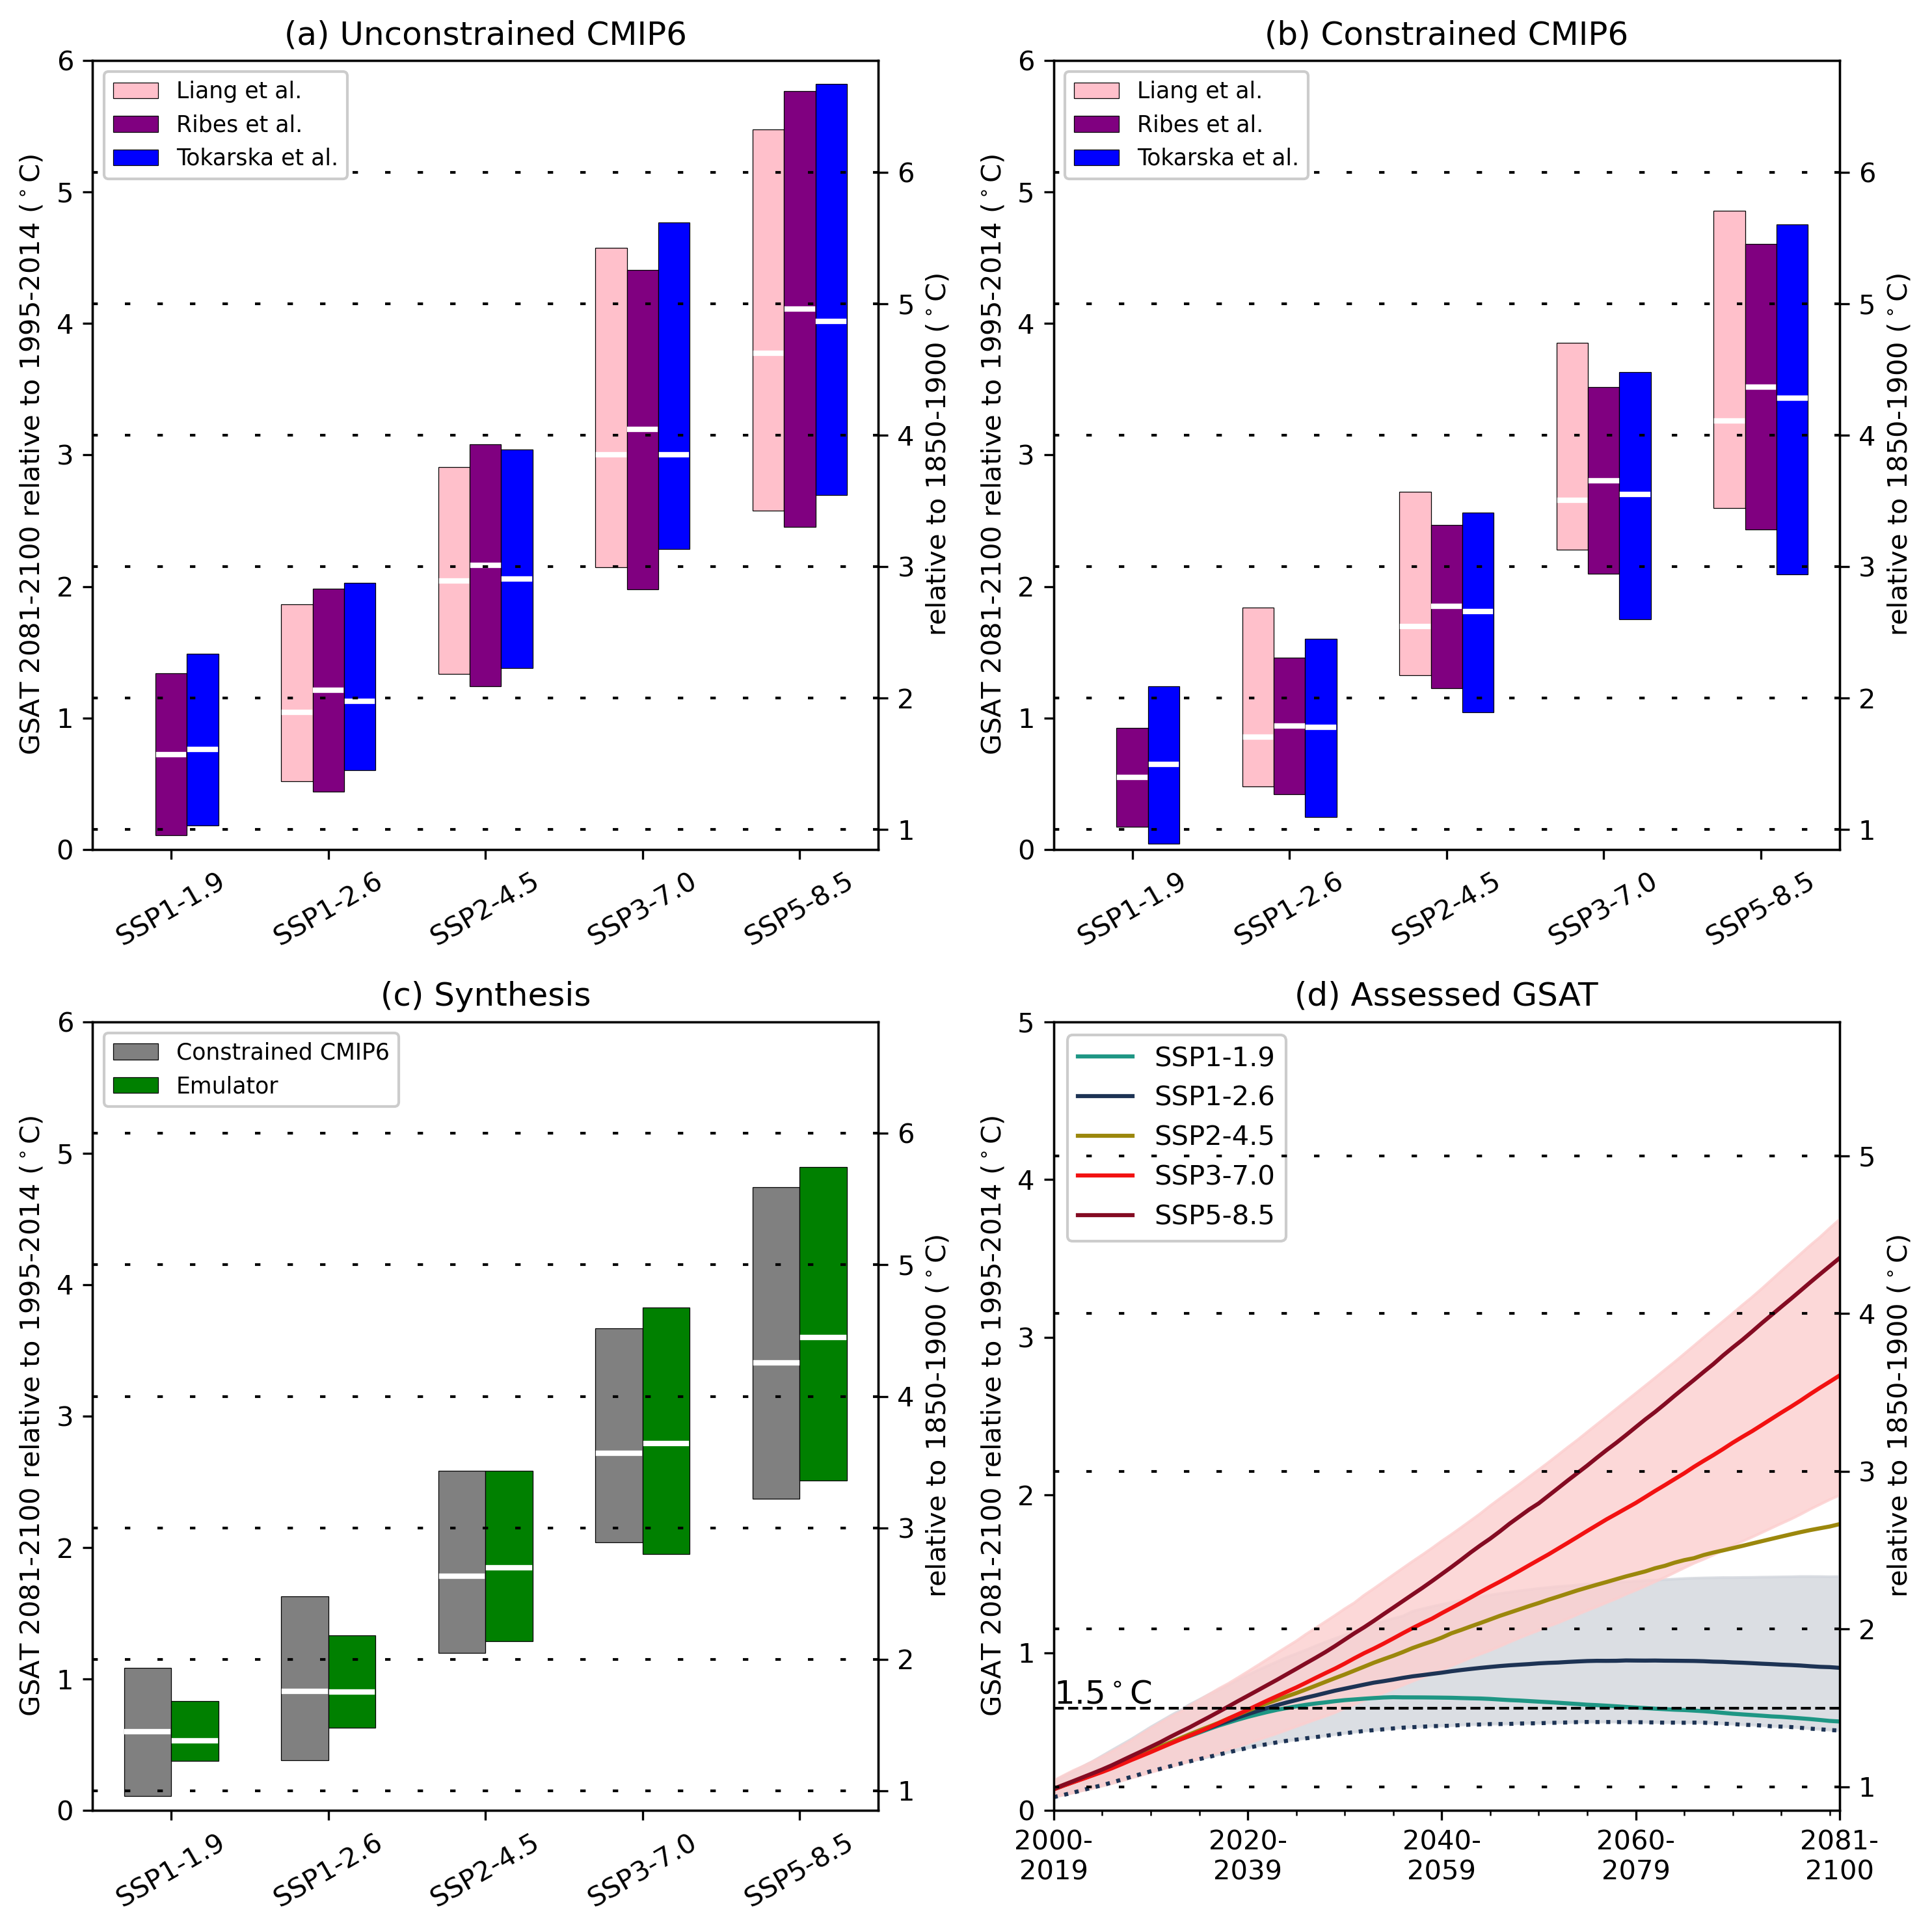

In [76]:
fig, axes = plt.subplots(2,2, figsize=(10,10))



## Panel a
# unconstrained CMIP6

xpos = [1,2,3,4,5]
xlabel = ['SSP1-1.9','SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5']
idx_assessed = -1 
idx_emulator = -1
idx_constrained = -1
idx_tokarska = -1
idx_yongxiao = -1
idx_ribes = -1

barwidth = 0.2
barwidth_constrained = 0.2
shift_dist = 0 # 

# left and right borders of bars
ll = -1.5*barwidth
lr = -0.5*barwidth
cl = lr
cr = +0.5*barwidth
rl = cr
rr = +1.5*barwidth

###################################
###################################
# SSP1-1.9

## raw

# Ribes
left = xpos[0]+cl
right = xpos[0]+cr
upper = ssp119_ribes_raw['Q95'][idx_ribes]
mid = ssp119_ribes_raw['mean'][idx_ribes]
lower = ssp119_ribes_raw['Q05'][idx_ribes]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[0]+rl
right = xpos[0]+rr
upper = ssp119_tokarska_raw['Q95'][idx_tokarska]
mid = ssp119_tokarska_raw['median'][idx_tokarska]
lower = ssp119_tokarska_raw['Q05'][idx_tokarska]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

###################################
###################################
# SSP1-2.6

##raw

# Liang
left = xpos[1]+ll
right = xpos[1]+lr
upper = ssp126_yongxiao_raw['Q95'][idx_yongxiao]
mid = ssp126_yongxiao_raw['median'][idx_yongxiao]
lower = ssp126_yongxiao_raw['Q05'][idx_yongxiao]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='Liang et al.');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[1]+cl
right = xpos[1]+cr
upper = ssp126_ribes_raw['Q95'][idx_ribes]
mid = ssp126_ribes_raw['mean'][idx_ribes]
lower = ssp126_ribes_raw['Q05'][idx_ribes]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='Ribes et al.');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[1]+rl
right = xpos[1]+rr
upper = ssp126_tokarska_raw['Q95'][idx_tokarska]
mid = ssp126_tokarska_raw['median'][idx_tokarska]
lower = ssp126_tokarska_raw['Q05'][idx_tokarska]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='Tokarska et al.');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)




###################################
###################################
# SSP2-4.5

# Liang
left = xpos[2]+ll
right = xpos[2]+lr
upper = ssp245_yongxiao_raw['Q95'][idx_yongxiao]
mid = ssp245_yongxiao_raw['median'][idx_yongxiao]
lower = ssp245_yongxiao_raw['Q05'][idx_yongxiao]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[2]+cl
right = xpos[2]+cr
upper = ssp245_ribes_raw['Q95'][idx_ribes]
mid = ssp245_ribes_raw['mean'][idx_ribes]
lower = ssp245_ribes_raw['Q05'][idx_ribes]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[2]+rl
right = xpos[2]+rr
upper = ssp245_tokarska_raw['Q95'][idx_tokarska]
mid = ssp245_tokarska_raw['median'][idx_tokarska]
lower = ssp245_tokarska_raw['Q05'][idx_tokarska]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)


###################################
###################################
# SSP3-7.0
# Liang
left = xpos[3]+ll
right = xpos[3]+lr
upper = ssp370_yongxiao_raw['Q95'][idx_yongxiao]
mid = ssp370_yongxiao_raw['median'][idx_yongxiao]
lower = ssp370_yongxiao_raw['Q05'][idx_yongxiao]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[3]+cl
right = xpos[3]+cr
upper = ssp370_ribes_raw['Q95'][idx_ribes]
mid = ssp370_ribes_raw['mean'][idx_ribes]
lower = ssp370_ribes_raw['Q05'][idx_ribes]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[3]+rl
right = xpos[3]+rr
upper = ssp370_tokarska_raw['Q95'][idx_tokarska]
mid = ssp370_tokarska_raw['median'][idx_tokarska]
lower = ssp370_tokarska_raw['Q05'][idx_tokarska]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)
###################################
###################################
# SSP5-8.5

# Liang
left = xpos[4]+ll
right = xpos[4]+lr
upper = ssp585_yongxiao_raw['Q95'][idx_yongxiao]
mid = ssp585_yongxiao_raw['median'][idx_yongxiao]
lower = ssp585_yongxiao_raw['Q05'][idx_yongxiao]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[4]+cl
right = xpos[4]+cr
upper = ssp585_ribes_raw['Q95'][idx_ribes]
mid = ssp585_ribes_raw['mean'][idx_ribes]
lower = ssp585_ribes_raw['Q05'][idx_ribes]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[4]+rl
right = xpos[4]+rr
upper = ssp585_tokarska_raw['Q95'][idx_tokarska]
mid = ssp585_tokarska_raw['median'][idx_tokarska]
lower = ssp585_tokarska_raw['Q05'][idx_tokarska]
axes[0,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)


axes[0,0].set_title('(a) Unconstrained CMIP6')
axes[0,0].set_xlim([0.5,5.5])
axes[0,0].set_ylim([0,6])
axes[0,0].set_xticks(xpos)
axes[0,0].set_xticklabels(xlabel, rotation=30)

axes[0,0].set_ylabel('GSAT 2081-2100 relative to '+str(refperiod_start)+'-'+str(refperiod_end)+' ($^\circ$C)')

legend = axes[0,0].legend(loc='upper left', shadow=False, fontsize='small',ncol=1,frameon=True,facecolor='white', framealpha=1)    

for yval in range(1,7):
    axes[0,0].plot([0.5,5.5],[yval-refperiod_conversion,yval-refperiod_conversion], color='black', dashes=(2, 10),linewidth=1)
ax2 = axes[0,0].twinx()
mn, mx = axes[0,0].get_ylim()
ax2.set_ylim(mn + refperiod_conversion, mx + refperiod_conversion) 
ax2.set_ylabel('relative to '+str(piperiod_start)+'-'+str(piperiod_end)+' ($^\circ$C)')




axes[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

axes[0,0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off




###############################################################################################################################################################################



## Panel b
# constrained CMIP6

xpos = [1,2,3,4,5]
xlabel = ['SSP1-1.9','SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5']
idx_assessed = -1 
idx_emulator = -1
idx_constrained = -1
idx_tokarska = -1
idx_yongxiao = -1
idx_ribes = -1

barwidth = 0.2
barwidth_constrained = 0.2
shift_dist = 0 

# left and right borders of bars
ll = -1.5*barwidth
lr = -0.5*barwidth
cl = lr
cr = +0.5*barwidth
rl = cr
rr = +1.5*barwidth

###################################
###################################
# SSP1-1.9

# Ribes
left = xpos[0]+cl
right = xpos[0]+cr
upper = ssp119_ribes['Q95'][idx_ribes]
mid = ssp119_ribes['mean'][idx_ribes]
lower = ssp119_ribes['Q05'][idx_ribes]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[0]+rl
right = xpos[0]+rr
upper = ssp119_tokarska['Q95'][idx_tokarska]
mid = ssp119_tokarska['median'][idx_tokarska]
lower = ssp119_tokarska['Q05'][idx_tokarska]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

###################################
###################################
# SSP1-2.6

##raw

# Liang
left = xpos[1]+ll
right = xpos[1]+lr
upper = ssp126_yongxiao['Q95'][idx_yongxiao]
mid = ssp126_yongxiao['median'][idx_yongxiao]
lower = ssp126_yongxiao['Q05'][idx_yongxiao]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='Liang et al.');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[1]+cl
right = xpos[1]+cr
upper = ssp126_ribes['Q95'][idx_ribes]
mid = ssp126_ribes['mean'][idx_ribes]
lower = ssp126_ribes['Q05'][idx_ribes]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='Ribes et al.');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[1]+rl
right = xpos[1]+rr
upper = ssp126_tokarska['Q95'][idx_tokarska]
mid = ssp126_tokarska['median'][idx_tokarska]
lower = ssp126_tokarska['Q05'][idx_tokarska]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='Tokarska et al.');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)




###################################
###################################
# SSP2-4.5

# Liang
left = xpos[2]+ll
right = xpos[2]+lr
upper = ssp245_yongxiao['Q95'][idx_yongxiao]
mid = ssp245_yongxiao['median'][idx_yongxiao]
lower = ssp245_yongxiao['Q05'][idx_yongxiao]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[2]+cl
right = xpos[2]+cr
upper = ssp245_ribes['Q95'][idx_ribes]
mid = ssp245_ribes['mean'][idx_ribes]
lower = ssp245_ribes['Q05'][idx_ribes]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[2]+rl
right = xpos[2]+rr
upper = ssp245_tokarska['Q95'][idx_tokarska]
mid = ssp245_tokarska['median'][idx_tokarska]
lower = ssp245_tokarska['Q05'][idx_tokarska]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)


###################################
###################################
# SSP3-7.0
# Liang
left = xpos[3]+ll
right = xpos[3]+lr
upper = ssp370_yongxiao['Q95'][idx_yongxiao]
mid = ssp370_yongxiao['median'][idx_yongxiao]
lower = ssp370_yongxiao['Q05'][idx_yongxiao]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[3]+cl
right = xpos[3]+cr
upper = ssp370_ribes['Q95'][idx_ribes]
mid = ssp370_ribes['mean'][idx_ribes]
lower = ssp370_ribes['Q05'][idx_ribes]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[3]+rl
right = xpos[3]+rr
upper = ssp370_tokarska['Q95'][idx_tokarska]
mid = ssp370_tokarska['median'][idx_tokarska]
lower = ssp370_tokarska['Q05'][idx_tokarska]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)
###################################
###################################
# SSP5-8.5

# Liang
left = xpos[4]+ll
right = xpos[4]+lr
upper = ssp585_yongxiao['Q95'][idx_yongxiao]
mid = ssp585_yongxiao['median'][idx_yongxiao]
lower = ssp585_yongxiao['Q05'][idx_yongxiao]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='pink',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Ribes
left = xpos[4]+cl
right = xpos[4]+cr
upper = ssp585_ribes['Q95'][idx_ribes]
mid = ssp585_ribes['mean'][idx_ribes]
lower = ssp585_ribes['Q05'][idx_ribes]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='purple',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Tokarska
left = xpos[4]+rl
right = xpos[4]+rr
upper = ssp585_tokarska['Q95'][idx_tokarska]
mid = ssp585_tokarska['median'][idx_tokarska]
lower = ssp585_tokarska['Q05'][idx_tokarska]
axes[0,1].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='blue',edgecolor='black',linewidth=0.3,label='');
axes[0,1].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)


axes[0,1].set_title('(b) Constrained CMIP6')
axes[0,1].set_xlim([0.5,5.5])
axes[0,1].set_ylim([0,6])
axes[0,1].set_xticks(xpos)
axes[0,1].set_xticklabels(xlabel, rotation=30)

axes[0,1].set_ylabel('GSAT 2081-2100 relative to '+str(refperiod_start)+'-'+str(refperiod_end)+' ($^\circ$C)')

legend = axes[0,1].legend(loc='upper left', shadow=False, fontsize='small',ncol=1,frameon=True,facecolor='white', framealpha=1)    

for yval in range(1,7):
    axes[0,1].plot([0.5,5.5],[yval-refperiod_conversion,yval-refperiod_conversion], color='black', dashes=(2, 10),linewidth=1)
ax2 = axes[0,1].twinx()
mn, mx = axes[0,1].get_ylim()
ax2.set_ylim(mn + refperiod_conversion, mx + refperiod_conversion) 
ax2.set_ylabel('relative to '+str(piperiod_start)+'-'+str(piperiod_end)+' ($^\circ$C)')




axes[0,1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

axes[0,1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off



###############################################################################################################################################################################



## Panel c
# Synthesis

xpos = [1,2,3,4,5]
xlabel = ['SSP1-1.9','SSP1-2.6','SSP2-4.5','SSP3-7.0','SSP5-8.5']
idx_assessed = -1 
idx_emulator = -1
idx_constrained = -1
idx_tokarska = -1
idx_yongxiao = -1
idx_ribes = -1

barwidth = 0.3
barwidth_constrained = 0.2
shift_dist = 0 

# left and right borders of bars
ll = -1*barwidth
lr = -0
rl = lr
rr = +1*barwidth

###################################
###################################
# SSP1-1.9

# Constrained
left = xpos[0]+ll
right = xpos[0]+lr
upper = ssp119_constrained_Q95[idx_constrained]
mid = ssp119_constrained_mean[idx_constrained]
lower = ssp119_constrained_Q05[idx_constrained]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='grey',edgecolor='black',linewidth=0.3,label='Constrained CMIP6');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Emulator
left = xpos[0]+rl
right = xpos[0]+rr
upper = ssp119_emulator['Q95'][idx_emulator]
mid = ssp119_emulator['mean'][idx_emulator]
lower = ssp119_emulator['Q05'][idx_emulator]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='green',edgecolor='black',linewidth=0.3,label='Emulator');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)




###################################
###################################
# SSP1-2.6

# Constrained
left = xpos[1]+ll
right = xpos[1]+lr
upper = ssp126_constrained_Q95[idx_constrained]
mid = ssp126_constrained_mean[idx_constrained]
lower = ssp126_constrained_Q05[idx_constrained]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='grey',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Emulator
left = xpos[1]+rl
right = xpos[1]+rr
upper = ssp126_emulator['Q95'][idx_emulator]
mid = ssp126_emulator['mean'][idx_emulator]
lower = ssp126_emulator['Q05'][idx_emulator]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='green',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)



###################################
###################################
# SSP2-4.5

# Constrained
left = xpos[2]+ll
right = xpos[2]+lr
upper = ssp245_constrained_Q95[idx_constrained]
mid = ssp245_constrained_mean[idx_constrained]
lower = ssp245_constrained_Q05[idx_constrained]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='grey',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Emulator
left = xpos[2]+rl
right = xpos[2]+rr
upper = ssp245_emulator['Q95'][idx_emulator]
mid = ssp245_emulator['mean'][idx_emulator]
lower = ssp245_emulator['Q05'][idx_emulator]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='green',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

###################################
###################################
# SSP3-7.0
# Constrained
left = xpos[3]+ll
right = xpos[3]+lr
upper = ssp370_constrained_Q95[idx_constrained]
mid = ssp370_constrained_mean[idx_constrained]
lower = ssp370_constrained_Q05[idx_constrained]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='grey',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Emulator
left = xpos[3]+rl
right = xpos[3]+rr
upper = ssp370_emulator['Q95'][idx_emulator]
mid = ssp370_emulator['mean'][idx_emulator]
lower = ssp370_emulator['Q05'][idx_emulator]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='green',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

###################################
###################################
# SSP5-8.5
# Constrained
left = xpos[4]+ll
right = xpos[4]+lr
upper = ssp585_constrained_Q95[idx_constrained]
mid = ssp585_constrained_mean[idx_constrained]
lower = ssp585_constrained_Q05[idx_constrained]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='grey',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)

# Emulator
left = xpos[4]+rl
right = xpos[4]+rr
upper = ssp585_emulator['Q95'][idx_emulator]
mid = ssp585_emulator['mean'][idx_emulator]
lower = ssp585_emulator['Q05'][idx_emulator]
axes[1,0].fill([left,right,right,left],
               [lower,lower,upper,upper],
               facecolor='green',edgecolor='black',linewidth=0.3,label='');
axes[1,0].plot([left+0.02,right-0.02],[mid,mid],color='white',linewidth=2)


axes[1,0].set_title('(c) Synthesis')
axes[1,0].set_xlim([0.5,5.5])
axes[1,0].set_ylim([0,6])
axes[1,0].set_xticks(xpos)
axes[1,0].set_xticklabels(xlabel, rotation=30)

axes[1,0].set_ylabel('GSAT 2081-2100 relative to '+str(refperiod_start)+'-'+str(refperiod_end)+' ($^\circ$C)')

legend = axes[1,0].legend(loc='upper left', shadow=False, fontsize='small',ncol=1,frameon=True,facecolor='white', framealpha=1)    

for yval in range(1,7):
    axes[1,0].plot([0.5,5.5],[yval-refperiod_conversion,yval-refperiod_conversion], color='black', dashes=(2, 10),linewidth=1)
ax2 = axes[1,0].twinx()
mn, mx = axes[1,0].get_ylim()
ax2.set_ylim(mn + refperiod_conversion, mx + refperiod_conversion) # add offset here if necessary
ax2.set_ylabel('relative to '+str(piperiod_start)+'-'+str(piperiod_end)+' ($^\circ$C)')




axes[1,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

axes[1,0].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True) # labels along the bottom edge are off



###############################################################################################################################################################################

# panel d
# assessed GSAT

# Note: long_time concatenates the time axis and the reversed time axis to plot the outlined of a polygon for the 5-95% range
# The very likely ranges are only plotted for SSP1-2.6 and SSP3-7.0 in figure 4.11.
# By uncommenting the lines for other scenarios, the very likely ranges for oher scenarios can be added to the panel.
# time axis with integer years
integer_times = np.arange(2000,2082,1)


# ssp119
axes[1,1].plot(integer_times,ssp119_assessed_mean,color=color_119,label=label_ssp119,zorder=40);
# long_time=np.append(integer_times,integer_times[::-1])
# axes[1,1].fill(long_time,np.append(ssp119_assessed_Q05,ssp119_assessed_Q95[::-1]),color=color_119_shading,alpha=0.8,label='',zorder=20)
# ssp126
axes[1,1].plot(integer_times,ssp126_assessed_mean,color=color_126,label=label_ssp126,zorder=40);
long_time=np.append(integer_times,integer_times[::-1])
axes[1,1].fill(long_time,np.append(ssp126_assessed_Q05,ssp126_assessed_Q95[::-1]),color=color_126_shading,alpha=0.8,label='',zorder=20)
axes[1,1].plot(integer_times,ssp126_assessed_Q05,color=color_126,linestyle=':',label='',zorder=40);

# ssp245
axes[1,1].plot(integer_times,ssp245_assessed_mean,color=color_245,label=label_ssp245,zorder=40);
# long_time=np.append(integer_times,integer_times[::-1])
# axes[1,1].fill(long_time,np.append(ssp245_assessed_Q05,ssp245_assessed_Q95[::-1]),color=color_245_shading,alpha=0.8,label='',zorder=20)
# ssp370
axes[1,1].plot(integer_times,ssp370_assessed_mean,color=color_370,label=label_ssp370,zorder=40);
long_time=np.append(integer_times,integer_times[::-1])
axes[1,1].fill(long_time,np.append(ssp370_assessed_Q05,ssp370_assessed_Q95[::-1]),color=color_370_shading,alpha=0.8,label='',zorder=20)
# ssp585
axes[1,1].plot(integer_times,ssp585_assessed_mean,color=color_585,label=label_ssp585,zorder=40);
# long_time=np.append(integer_times,integer_times[::-1])
# axes[1,1].fill(long_time,np.append(ssp585_assessed_Q05,ssp585_assessed_Q95[::-1]),color=color_585_shading,alpha=0.8,label='',zorder=20)


legend = axes[1,1].legend(loc='upper left', shadow=False,facecolor='white', framealpha=1)

for yval in range(1,7):
    axes[1,1].plot([2000,2081],[yval-refperiod_conversion,yval-refperiod_conversion], color='black', dashes=(2, 10),linewidth=1,zorder=41)

yval=1.5
axes[1,1].plot([2000,2081],[yval-refperiod_conversion,yval-refperiod_conversion], color='black',label='',linewidth=1,zorder=41, linestyle='--')
axes[1,1].text(2000, yval-refperiod_conversion+0.03, '1.5$^\circ$C',size=12, zorder=42)


axes[1,1].set_ylim([0,5])
axes[1,1].set_title('(d) Assessed GSAT')
axes[1,1].set_ylabel('GSAT 2081-2100 relative to '+str(refperiod_start)+'-'+str(refperiod_end)+' ($^\circ$C)')

# introduce second y-axis with different reference period
ax2 = axes[1,1].twinx()
mn, mx = axes[1,1].get_ylim()
ax2.set_ylim(mn+refperiod_conversion, mx+refperiod_conversion)
ax2.set_ylabel('relative to '+str(piperiod_start)+'-'+str(piperiod_end)+' ($^\circ$C)')


# Show ranges on x-axis
xticks=[2000,2020,2040,2060,2081]
xtick_labels = [str(i)+'-\n'+str(i+19) for i in xticks]
axes[1,1].set_xticks(xticks); axes[1,1].set_xticks(np.arange(2000,2100,5),minor=True)
axes[1,1].set_xticklabels(xtick_labels)
axes[1,1].set_xlim([2000,2081])


fig.tight_layout()
plt.savefig(plotdir+'figure_4.11.pdf', bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)